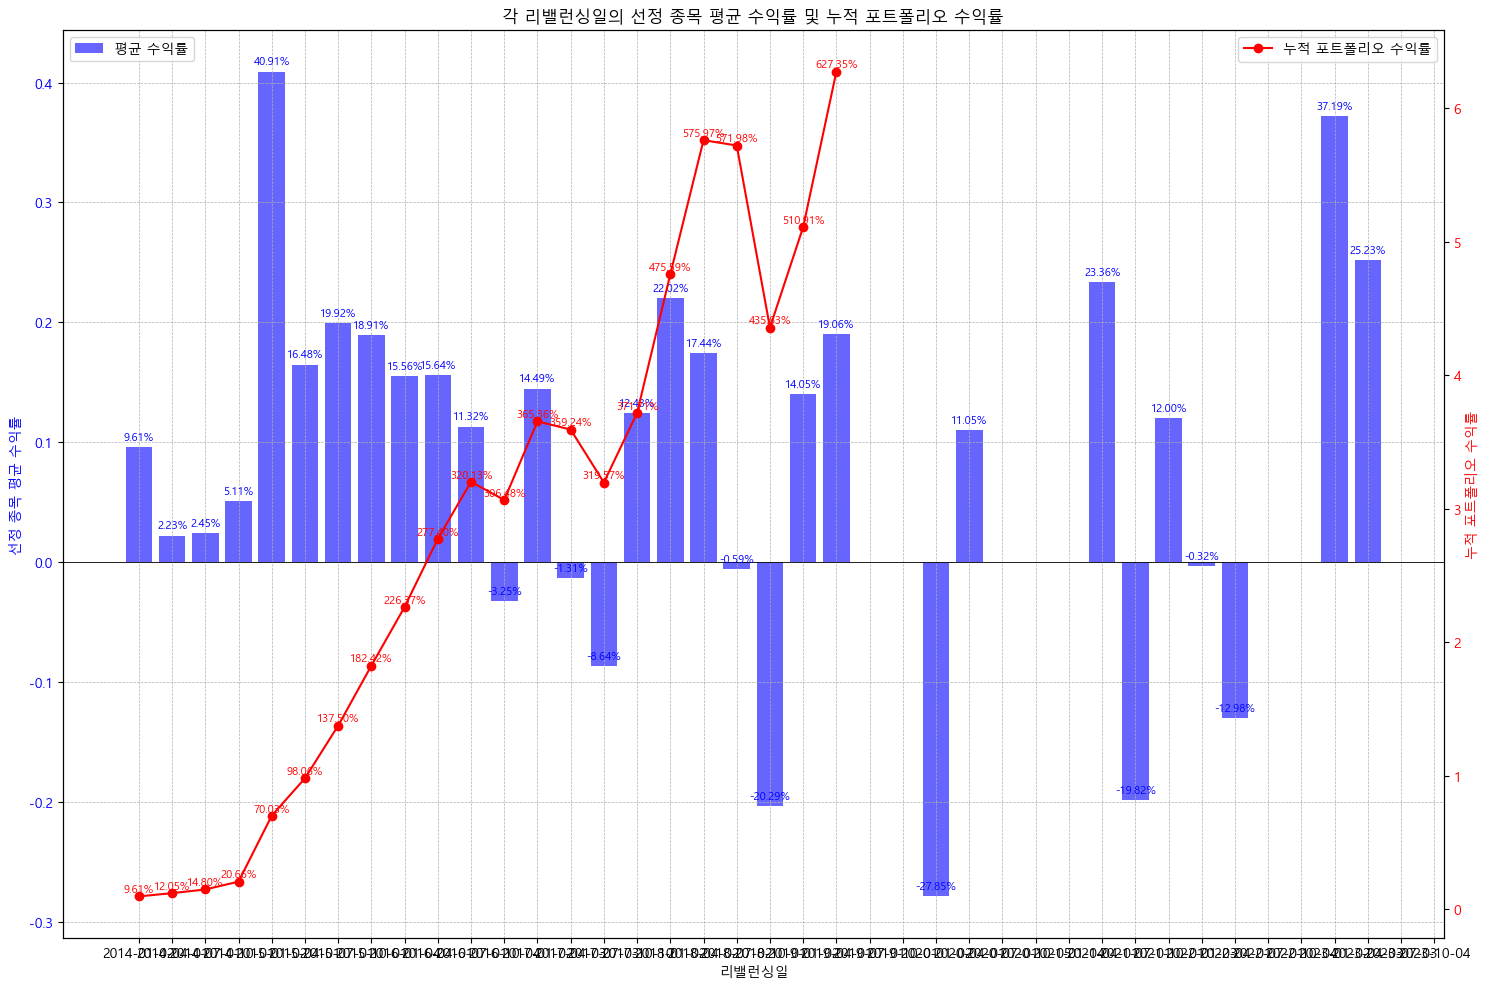

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
close_df = pd.read_csv('reshape_df.csv')

# 리밸런싱일 정의하기
rebalancing_dates = ['2014-01-02', '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']

# 각 리밸런싱일에 선정된 종목과 그 종목들의 수익률을 저장할 딕셔너리 초기화
held_stocks_dict = {}
stock_returns_dict = {}

# 각 리밸런싱일마다 종목 선정 및 수익률 계산
for idx, date in enumerate(rebalancing_dates):
    start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(date)
    period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
    
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    volatility = period_df[dropped_stocks].iloc[-60:].std()
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    held_stocks_dict[date] = selected_stocks
    
    next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else close_df['Date'].max()
    next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
    returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
    stock_returns_dict[date] = returns

portfolio_returns = {date: np.mean(returns) for date, returns in stock_returns_dict.items()}
cumulative_portfolio_returns = [np.prod([1 + ret for ret in portfolio_returns.values()][:i+1]) - 1 for i in range(len(portfolio_returns))]

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 10))
bars = ax1.bar(portfolio_returns.keys(), portfolio_returns.values(), color='blue', label='평균 수익률', alpha=0.6)
ax1.set_title('각 리밸런싱일의 선정 종목 평균 수익률 및 누적 포트폴리오 수익률')
ax1.set_xlabel('리밸런싱일')
ax1.set_ylabel('선정 종목 평균 수익률', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.axhline(0, color='black', linewidth=0.6)

for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2%}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8, color='blue')

ax2 = ax1.twinx()
lines, = ax2.plot(list(portfolio_returns.keys()), cumulative_portfolio_returns, color='red', label='누적 포트폴리오 수익률', marker='o')
ax2.set_ylabel('누적 포트폴리오 수익률', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for i, txt in enumerate(cumulative_portfolio_returns):
    ax2.annotate(f'{txt:.2%}', (list(portfolio_returns.keys())[i], cumulative_portfolio_returns[i]), textcoords="offset points", xytext=(0,3), ha='center', fontsize=8, color='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [3]:
def get_stock_codes_by_date(close_df, rebalancing_dates):
    held_stocks_dict = {}

    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)

        # 해당 기간의 데이터만 추출
        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')

        # 가격이 30% 이상 하락한 종목 찾기
        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()

        # 해당 종목들의 변동성 계산
        volatility = period_df[dropped_stocks].iloc[-60:].std()

        # 변동성이 낮은 종목 10개 선정
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()

        # 선정된 종목 저장
        held_stocks_dict[date] = selected_stocks

    return held_stocks_dict

stock_codes_by_date = get_stock_codes_by_date(close_df, rebalancing_dates)


In [4]:
from pykrx import stock

def get_company_names_from_pykrx(stock_codes):
    company_names_mapping = {}
    for code in stock_codes:
        company_name = stock.get_market_ticker_name(code)
        if company_name:
            company_names_mapping[code] = company_name
    return company_names_mapping

# 종목코드 리스트
stock_codes = [code for sublist in stock_codes_by_date.values() for code in sublist]
company_names = get_company_names_from_pykrx(stock_codes)
print(company_names)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
close_df = pd.read_csv('reshape_df.csv')

# 리밸런싱일 정의하기
rebalancing_dates = ['2014-01-02', '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']

def get_stock_codes_by_date(close_df, rebalancing_dates):
    held_stocks_dict = {}

    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)
        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')

        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
        volatility = period_df[dropped_stocks].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
        held_stocks_dict[date] = selected_stocks

    return held_stocks_dict

stock_codes_by_date = get_stock_codes_by_date(close_df, rebalancing_dates)

from pykrx import stock

def get_company_names_from_pykrx(stock_codes):
    company_names_mapping = {}
    for code in stock_codes:
        company_name = stock.get_market_ticker_name(code)
        if company_name:
            company_names_mapping[code] = company_name
    return company_names_mapping

stock_codes = [code for sublist in stock_codes_by_date.values() for code in sublist]
company_names_mapping = get_company_names_from_pykrx(stock_codes)

def plot_selected_stock_returns(start_date, end_date, selected_stocks, company_names_mapping):
    period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] <= end_date)][selected_stocks]
    returns = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    average_return = returns.mean()

    fig, ax = plt.subplots(figsize=(15, 10))
    company_names = [company_names_mapping[code] for code in selected_stocks]
    colors = plt.cm.Blues(np.linspace(0.5, 1, len(returns)))
    bars = ax.bar(company_names, returns.values * 100, color=colors, alpha=0.7)
    ax.axhline(average_return * 100, color='red', linestyle='--', linewidth=1.5, label='평균 수익률')
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')
    ax.annotate(f'평균 수익률: {average_return * 100:.2f}%',
                xy=(len(company_names)-1, average_return * 100),
                xytext=(5, 10),
                textcoords='offset points',
                fontsize=10,
                color='red',
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    ax.set_title(f'Alpha-investing Strategy A: {start_date}부터 {end_date}까지의 수익률', fontsize=16)
    ax.set_ylabel('수익률 (%)', fontsize=14)
    ax.set_xticks(company_names)
    ax.set_xticklabels(company_names, rotation=45, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()

for date in rebalancing_dates[:-1]:
    next_date = rebalancing_dates[rebalancing_dates.index(date) + 1]
    selected_stocks = stock_codes_by_date[date]
    plot_selected_stock_returns(date, next_date, selected_stocks, company_names_mapping)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

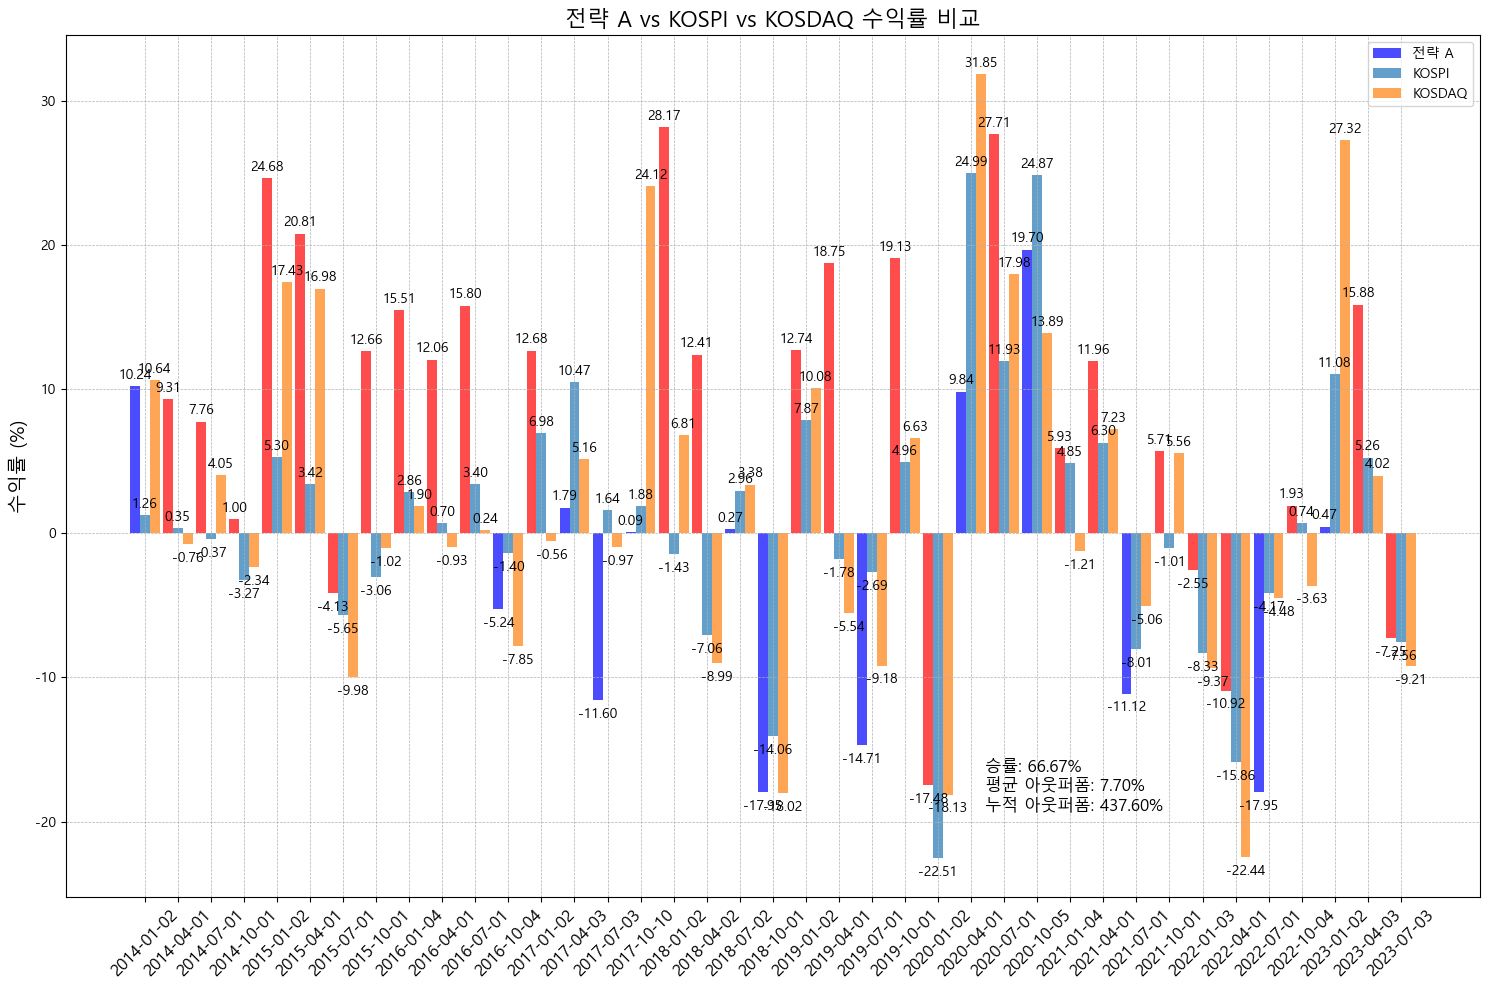

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
close_df = pd.read_csv('close_df.csv')
kospi_df = pd.read_csv('KOSPI Historical Data.csv')
kosdaq_df = pd.read_csv('KOSDAQ Historical Data.csv')

# 날짜 형식 변환 및 종가의 쉼표 제거
kospi_df['Date'] = pd.to_datetime(kospi_df['Date'])
kosdaq_df['Date'] = pd.to_datetime(kosdaq_df['Date'])
kospi_df['Price'] = kospi_df['Price'].str.replace(',', '').astype(float)
kosdaq_df['Price'] = kosdaq_df['Price'].str.replace(',', '').astype(float)

# 주어진 시작일과 종료일 사이의 수익률 계산 함수
def calculate_return(df, start_date, end_date):
    start_price = df[df['Date'] == start_date]['Price'].values[0]
    end_price = df[df['Date'] == end_date]['Price'].values[0]
    return 100 * (end_price - start_price) / start_price

winning_indices = []
outperform_values = []

# 각 리밸런싱일에 대한 전략 A, 코스피, 코스닥 수익률 계산
strategy_a_returns = []
kospi_returns = []
kosdaq_returns = []

for i in range(len(rebalancing_dates) - 1):
    start_date = rebalancing_dates[i]
    end_date = rebalancing_dates[i + 1]
    
    # 전략 A의 수익률
    strategy_a_stocks = stock_codes_by_date[start_date]
    period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] <= end_date)][strategy_a_stocks]
    strategy_a_return = 100 * ((period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]).mean()
    strategy_a_returns.append(strategy_a_return)
    
    # 코스피의 수익률
    kospi_return = calculate_return(kospi_df, start_date, end_date)
    kospi_returns.append(kospi_return)
    
    # 코스닥의 수익률
    kosdaq_return = calculate_return(kosdaq_df, start_date, end_date)
    kosdaq_returns.append(kosdaq_return)

    # 전략 A가 코스피와 코스닥을 모두 이긴 경우 해당 인덱스 저장 및 아웃퍼폼 값 계산
    if strategy_a_return > kospi_return and strategy_a_return > kosdaq_return:
        winning_indices.append(i)
        outperform_values.append(strategy_a_return - max(kospi_return, kosdaq_return))

# 승률 및 평균 아웃퍼폼 수치 계산
win_rate = len(winning_indices) / (len(rebalancing_dates) - 1)
avg_outperform = sum(outperform_values) / len(outperform_values)
cumulative_outperform = (np.prod(np.array(strategy_a_returns)/100 + 1) - np.prod(np.array(max(kospi_returns, kosdaq_returns))/100 + 1)) * 100

# 전략 A vs KOSPI vs KOSDAQ 수익률 비교 그래프 생성 함수
def plot_benchmark_comparison(strategy_returns, kospi_returns, kosdaq_returns, rebalancing_dates, winning_indices, win_rate, avg_outperform, cumulative_outperform):
    bar_width = 0.3
    index = np.arange(len(strategy_returns))
    
    fig, ax = plt.subplots(figsize=(15, 10))
    bars1 = ax.bar(index, strategy_returns, bar_width, label='전략 A', alpha=0.7, color=['red' if i in winning_indices else 'blue' for i in index])
    bars2 = ax.bar(index + bar_width, kospi_returns, bar_width, label='KOSPI', alpha=0.7)
    bars3 = ax.bar(index + 2 * bar_width, kosdaq_returns, bar_width, label='KOSDAQ', alpha=0.7)
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3 if height > 0 else -15),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, color='black')
    
    ax.set_title(f'전략 A vs KOSPI vs KOSDAQ 수익률 비교', fontsize=16)
    ax.set_ylabel('수익률 (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(rebalancing_dates[:-1], rotation=45, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()

    # 승률, 평균 아웃퍼폼, 누적 아웃퍼폼 정보 표시
    info_text = f"승률: {win_rate:.2%}\n평균 아웃퍼폼: {avg_outperform:.2f}%\n누적 아웃퍼폼: {cumulative_outperform:.2f}%"
    ax.annotate(info_text, xy=(0.65, 0.1), xycoords='axes fraction', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()

# 그래프 생성
plot_benchmark_comparison(strategy_a_returns, kospi_returns, kosdaq_returns, rebalancing_dates, winning_indices, win_rate, avg_outperform, cumulative_outperform)


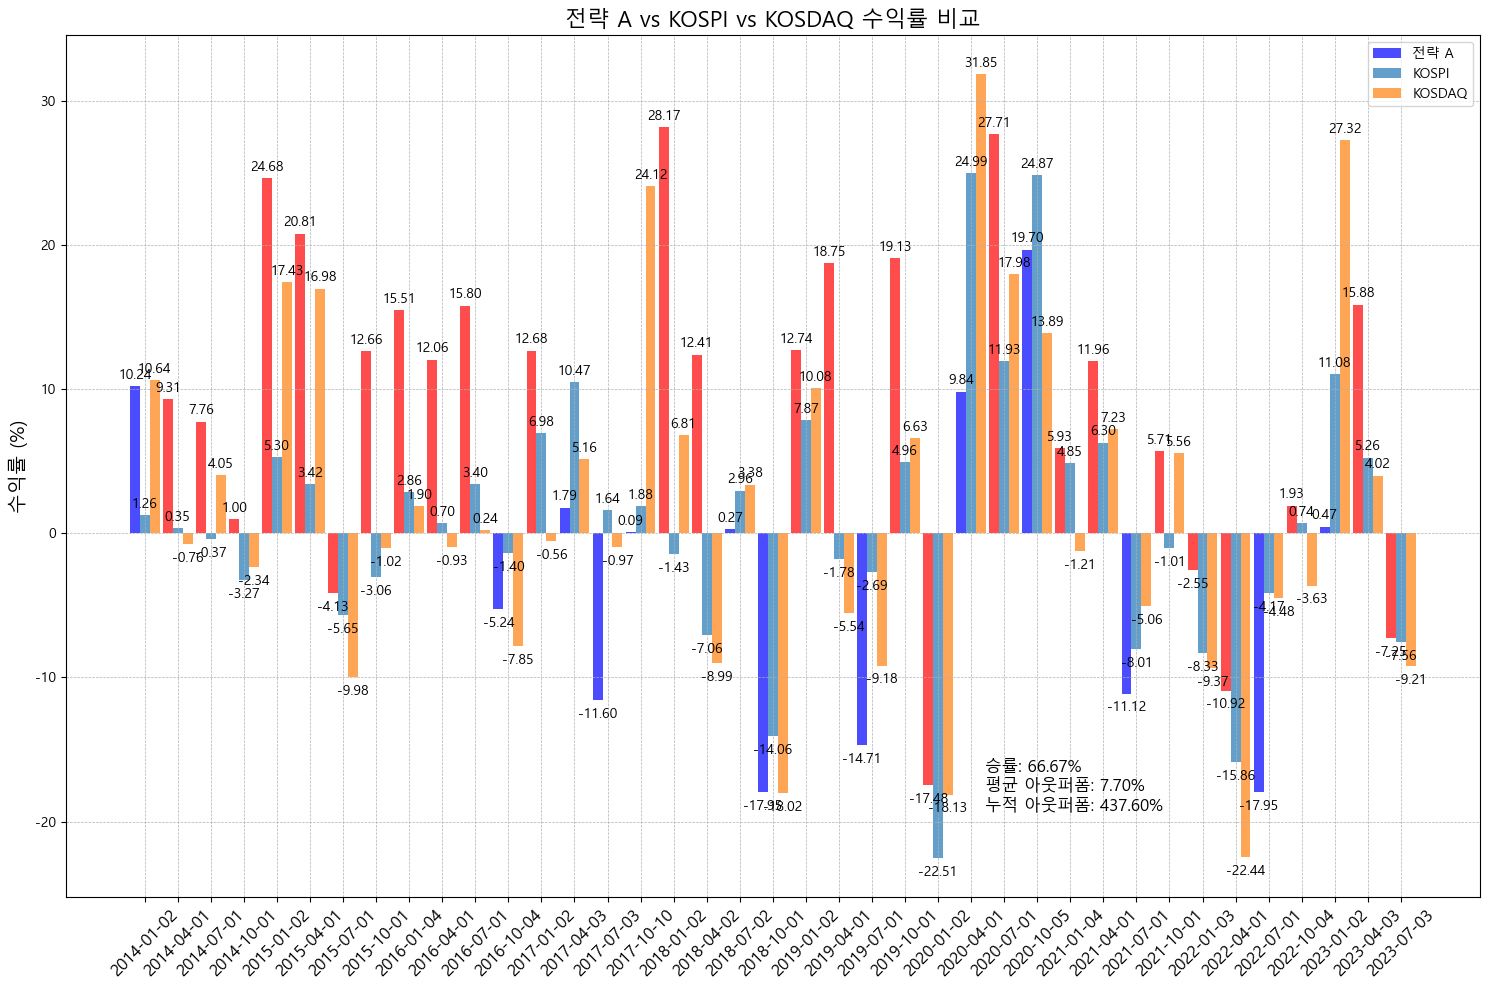

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def get_strategy_a_returns(close_df, stock_codes_by_date, rebalancing_dates):
    strategy_a_returns = []
    for i in range(len(rebalancing_dates) - 1):
        start_date = rebalancing_dates[i]
        end_date = rebalancing_dates[i + 1]
        strategy_a_stocks = stock_codes_by_date[start_date]
        period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] <= end_date)][strategy_a_stocks]
        strategy_a_return = 100 * ((period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]).mean()
        strategy_a_returns.append(strategy_a_return)
    return strategy_a_returns

def calculate_return(df, start_date, end_date):
    start_price = df[df['Date'] == start_date]['Price'].values[0]
    end_price = df[df['Date'] == end_date]['Price'].values[0]
    return 100 * (end_price - start_price) / start_price

def get_index_returns(index_df, rebalancing_dates):
    index_returns = []
    for i in range(len(rebalancing_dates) - 1):
        start_date = rebalancing_dates[i]
        end_date = rebalancing_dates[i + 1]
        index_return = calculate_return(index_df, start_date, end_date)
        index_returns.append(index_return)
    return index_returns

def get_win_rate_and_outperform(strategy_a_returns, kospi_returns, kosdaq_returns):
    winning_indices = []
    outperform_values = []

    for i, (strategy_return, kospi_return, kosdaq_return) in enumerate(zip(strategy_a_returns, kospi_returns, kosdaq_returns)):
        if strategy_return > kospi_return and strategy_return > kosdaq_return:
            winning_indices.append(i)
            outperform_values.append(strategy_return - max(kospi_return, kosdaq_return))

    win_rate = len(winning_indices) / len(strategy_a_returns)
    avg_outperform = sum(outperform_values) / len(outperform_values) if outperform_values else 0
    cumulative_outperform = (np.prod(np.array(strategy_a_returns)/100 + 1) - np.prod(np.array(max(kospi_returns, kosdaq_returns))/100 + 1)) * 100
    
    return win_rate, avg_outperform, cumulative_outperform, winning_indices

def plot_benchmark_comparison(strategy_a_returns, kospi_returns, kosdaq_returns, rebalancing_dates, winning_indices, win_rate, avg_outperform, cumulative_outperform):
    bar_width = 0.3
    index = np.arange(len(strategy_a_returns))
    fig, ax = plt.subplots(figsize=(15, 10))
    bars1 = ax.bar(index, strategy_a_returns, bar_width, label='전략 A', alpha=0.7, color=['red' if i in winning_indices else 'blue' for i in index])
    bars2 = ax.bar(index + bar_width, kospi_returns, bar_width, label='KOSPI', alpha=0.7)
    bars3 = ax.bar(index + 2 * bar_width, kosdaq_returns, bar_width, label='KOSDAQ', alpha=0.7)
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3 if height > 0 else -15), textcoords="offset points", ha='center', va='bottom', fontsize=10, color='black')
    ax.set_title(f'전략 A vs KOSPI vs KOSDAQ 수익률 비교', fontsize=16)
    ax.set_ylabel('수익률 (%)', fontsize=14)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(rebalancing_dates[:-1], rotation=45, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    info_text = f"승률: {win_rate:.2%}\n평균 아웃퍼폼: {avg_outperform:.2f}%\n누적 아웃퍼폼: {cumulative_outperform:.2f}%"
    ax.annotate(info_text, xy=(0.65, 0.1), xycoords='axes fraction', fontsize=12, color='black')
    plt.tight_layout()
    plt.show()

# 데이터 로드
close_df = pd.read_csv('close_df.csv')
kospi_df = pd.read_csv('KOSPI Historical Data.csv')
kosdaq_df = pd.read_csv('KOSDAQ Historical Data.csv')

# 날짜 형식 변환 및 종가의 쉼표 제거
kospi_df['Date'] = pd.to_datetime(kospi_df['Date'])
kosdaq_df['Date'] = pd.to_datetime(kosdaq_df['Date'])
kospi_df['Price'] = kospi_df['Price'].str.replace(',', '').astype(float)
kosdaq_df['Price'] = kosdaq_df['Price'].str.replace(',', '').astype(float)

# 사용
strategy_a_returns = get_strategy_a_returns(close_df, stock_codes_by_date, rebalancing_dates)
kospi_returns = get_index_returns(kospi_df, rebalancing_dates)
kosdaq_returns = get_index_returns(kosdaq_df, rebalancing_dates)
win_rate, avg_outperform, cumulative_outperform, winning_indices = get_win_rate_and_outperform(strategy_a_returns, kospi_returns, kosdaq_returns)
plot_benchmark_comparison(strategy_a_returns, kospi_returns, kosdaq_returns, rebalancing_dates, winning_indices, win_rate, avg_outperform, cumulative_outperform)


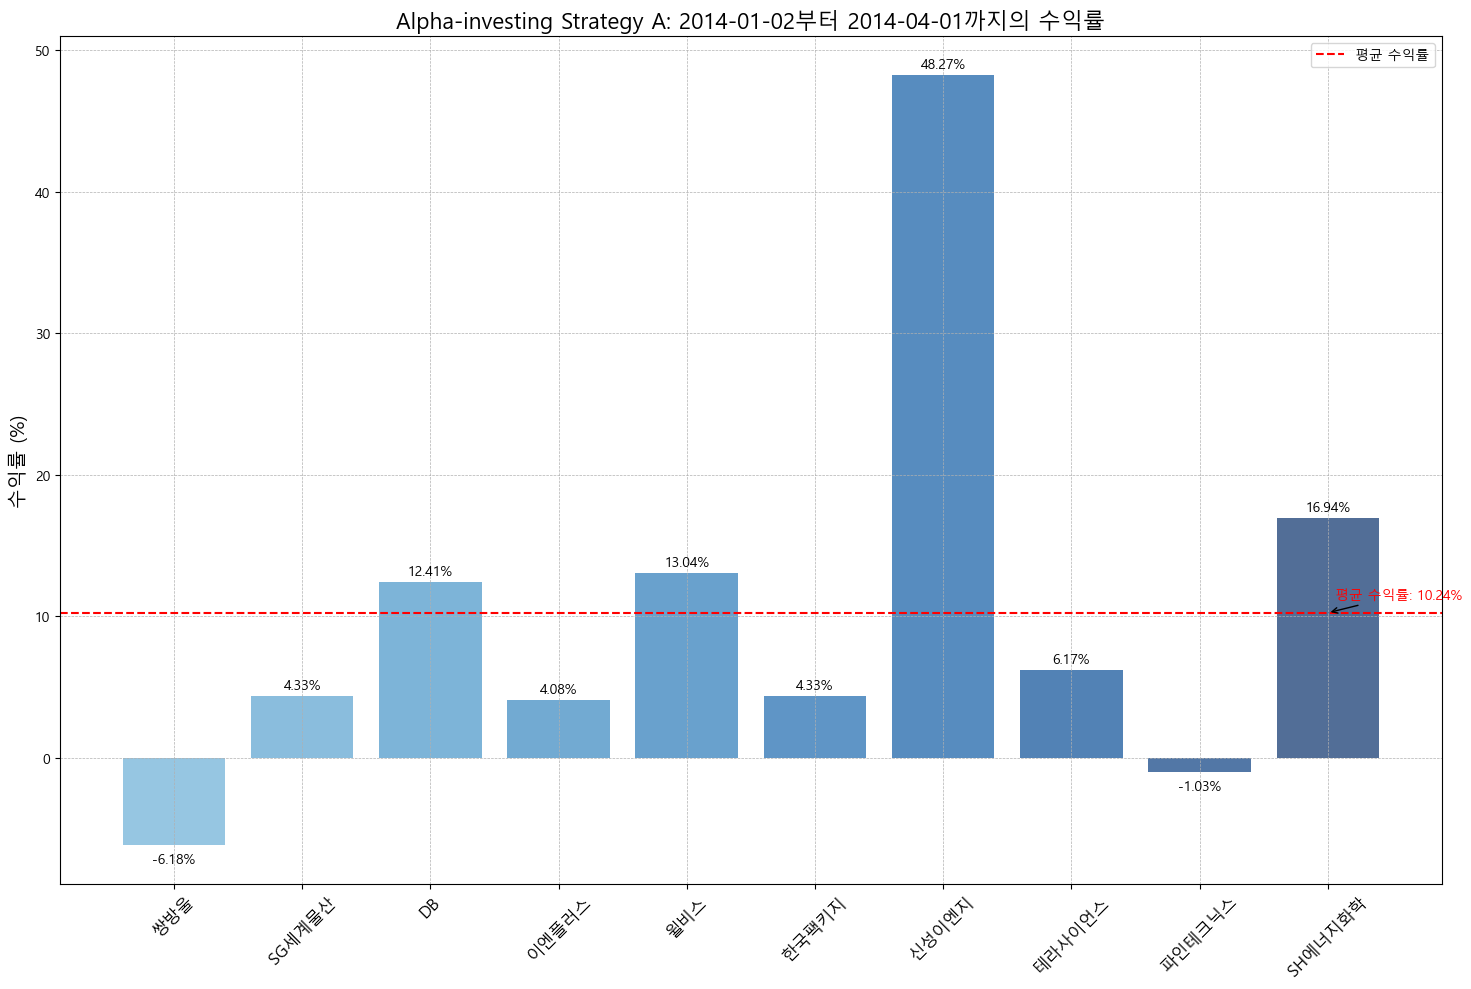

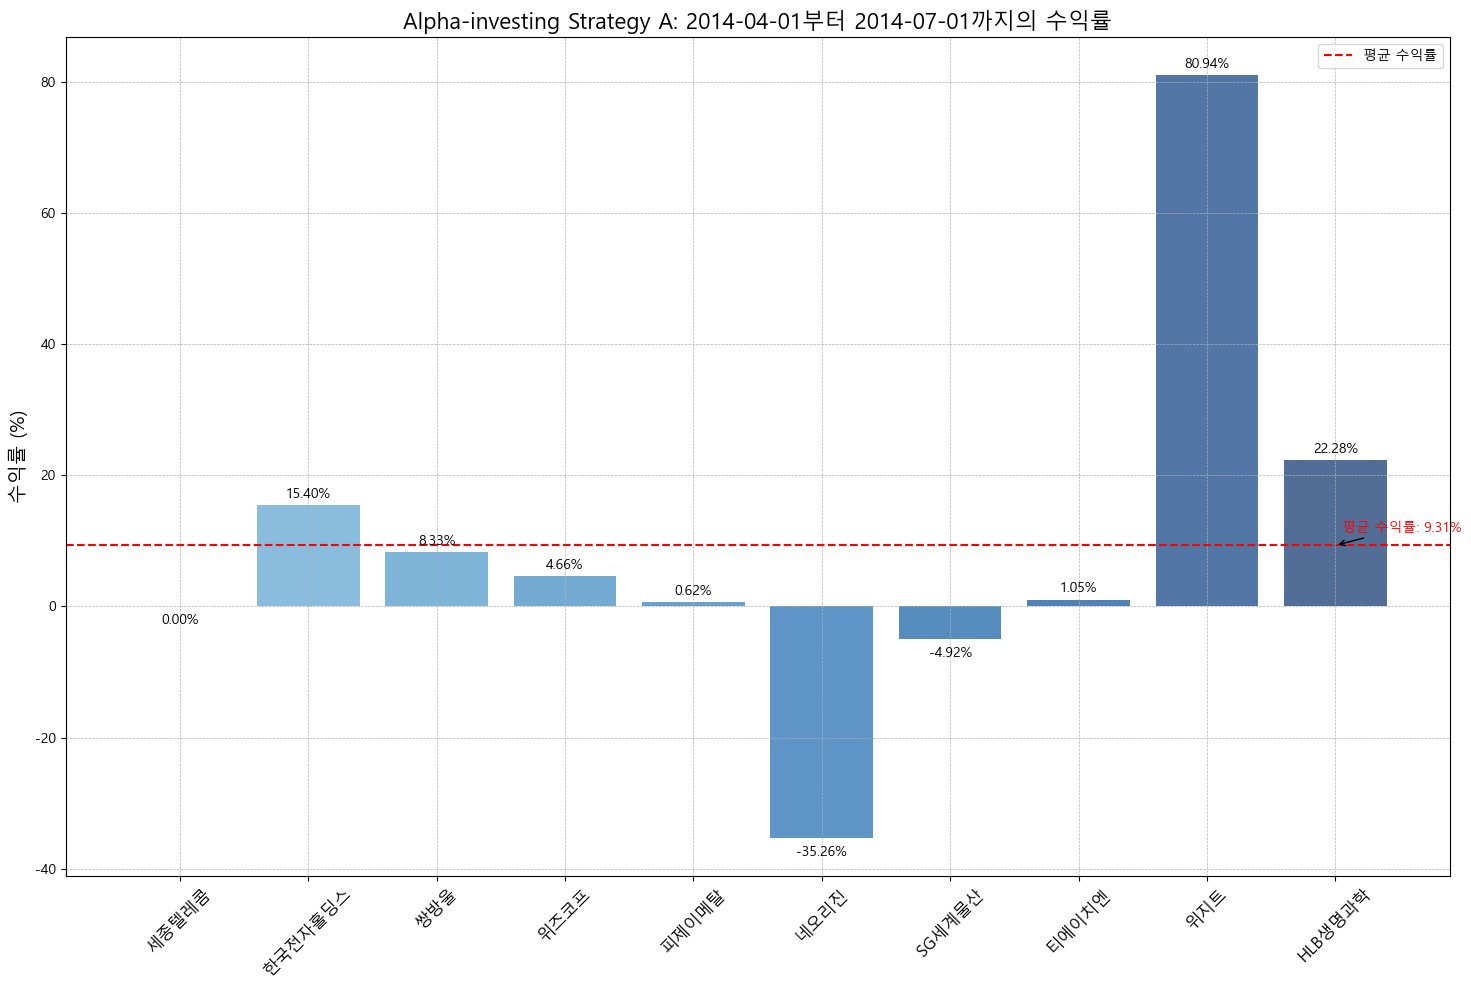

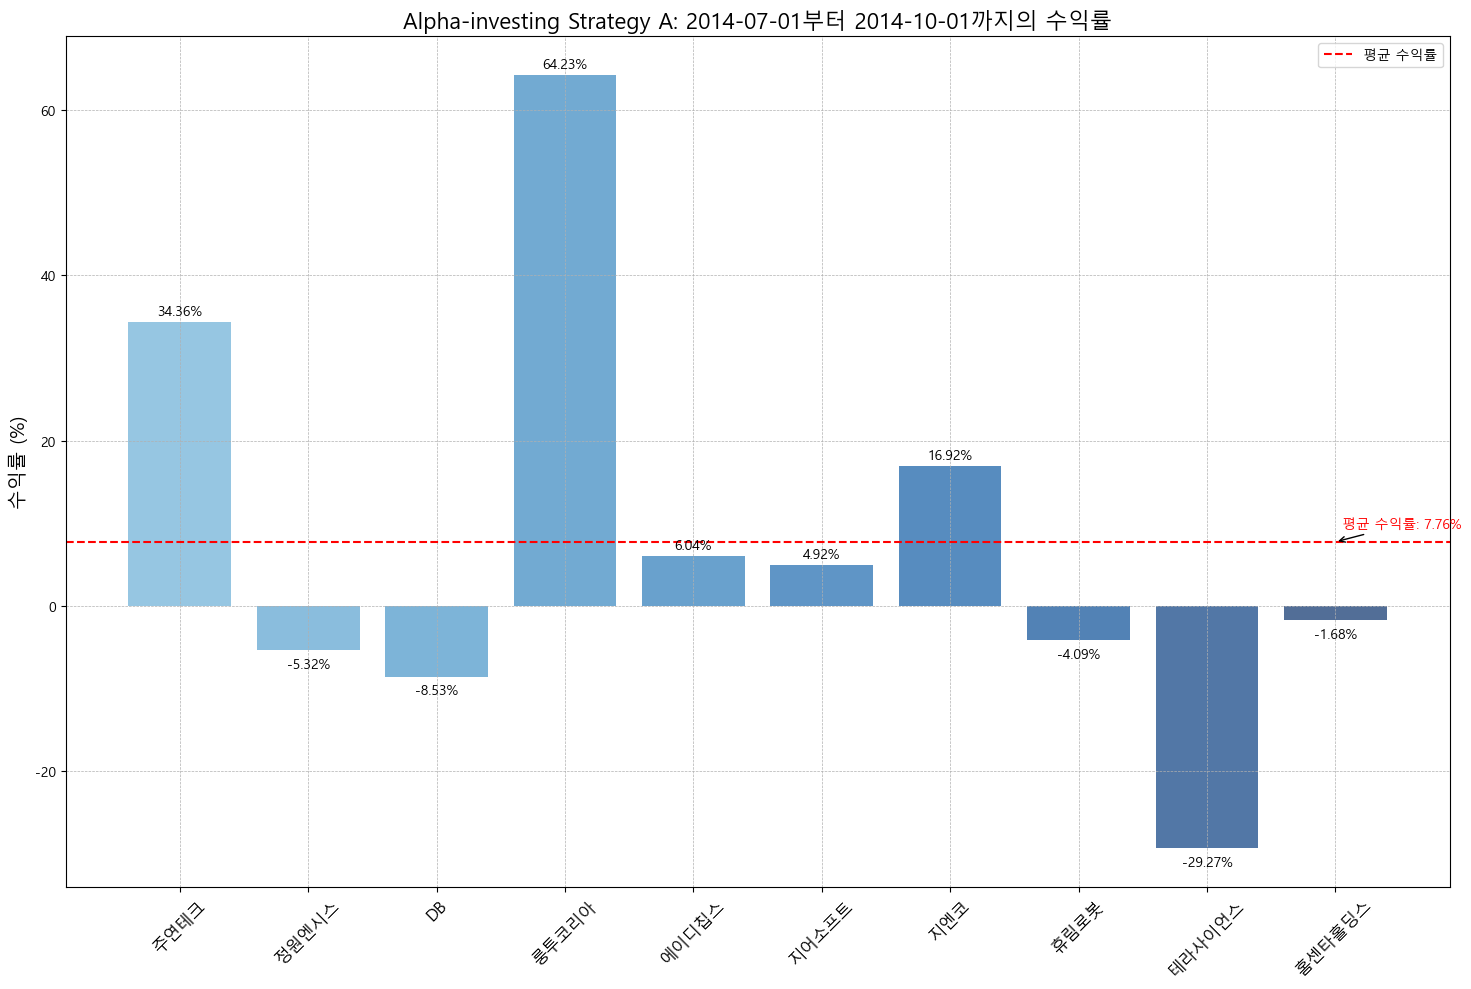

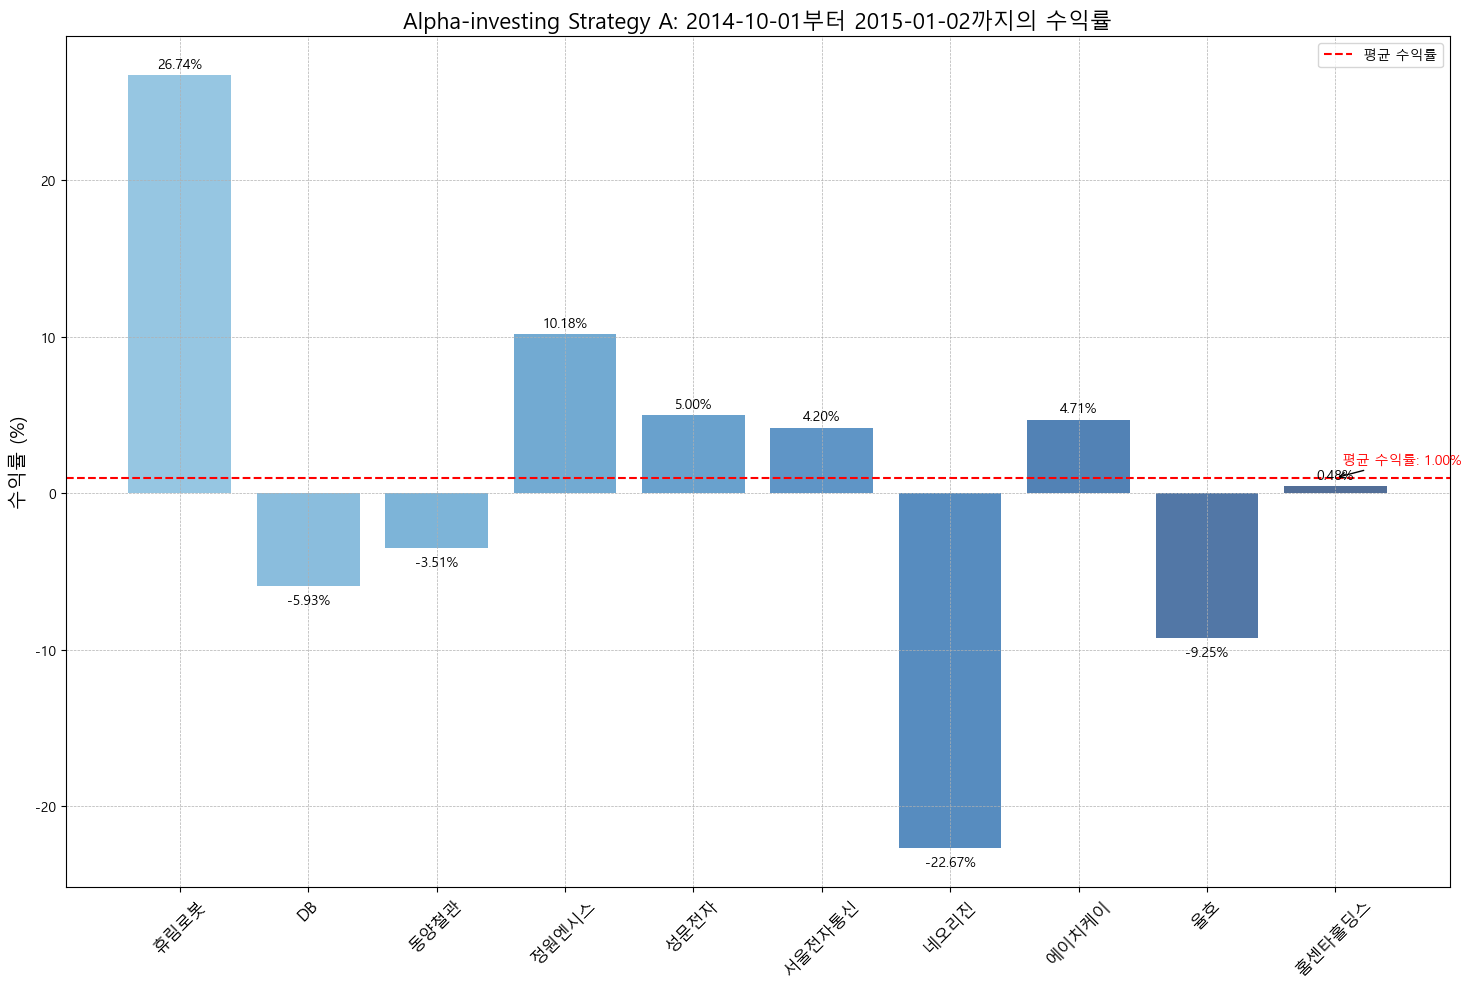

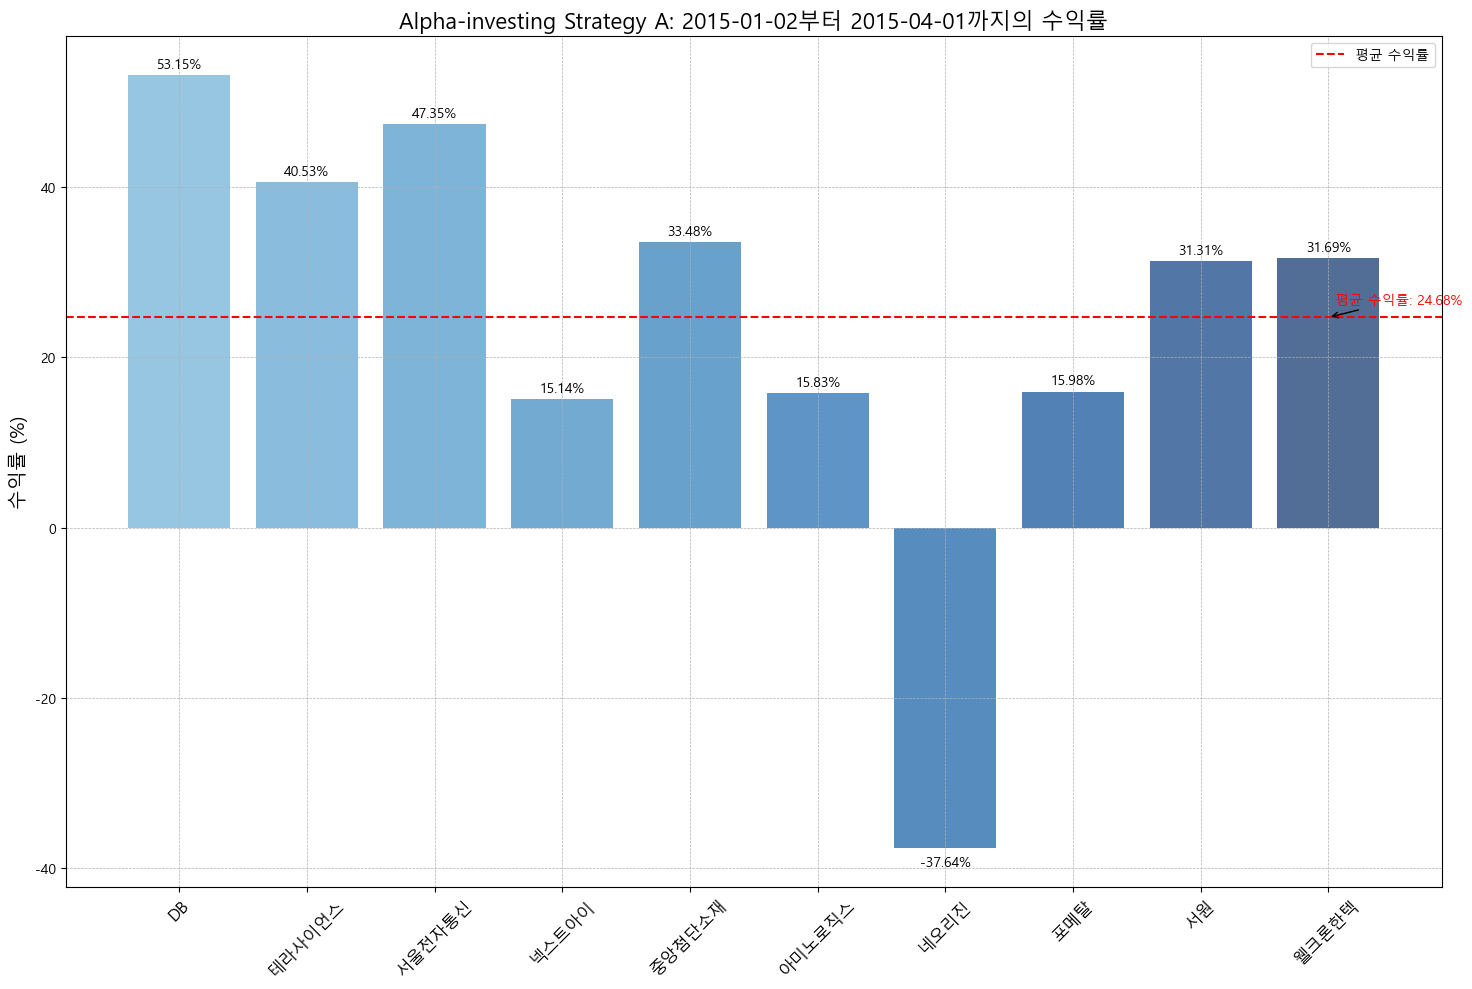

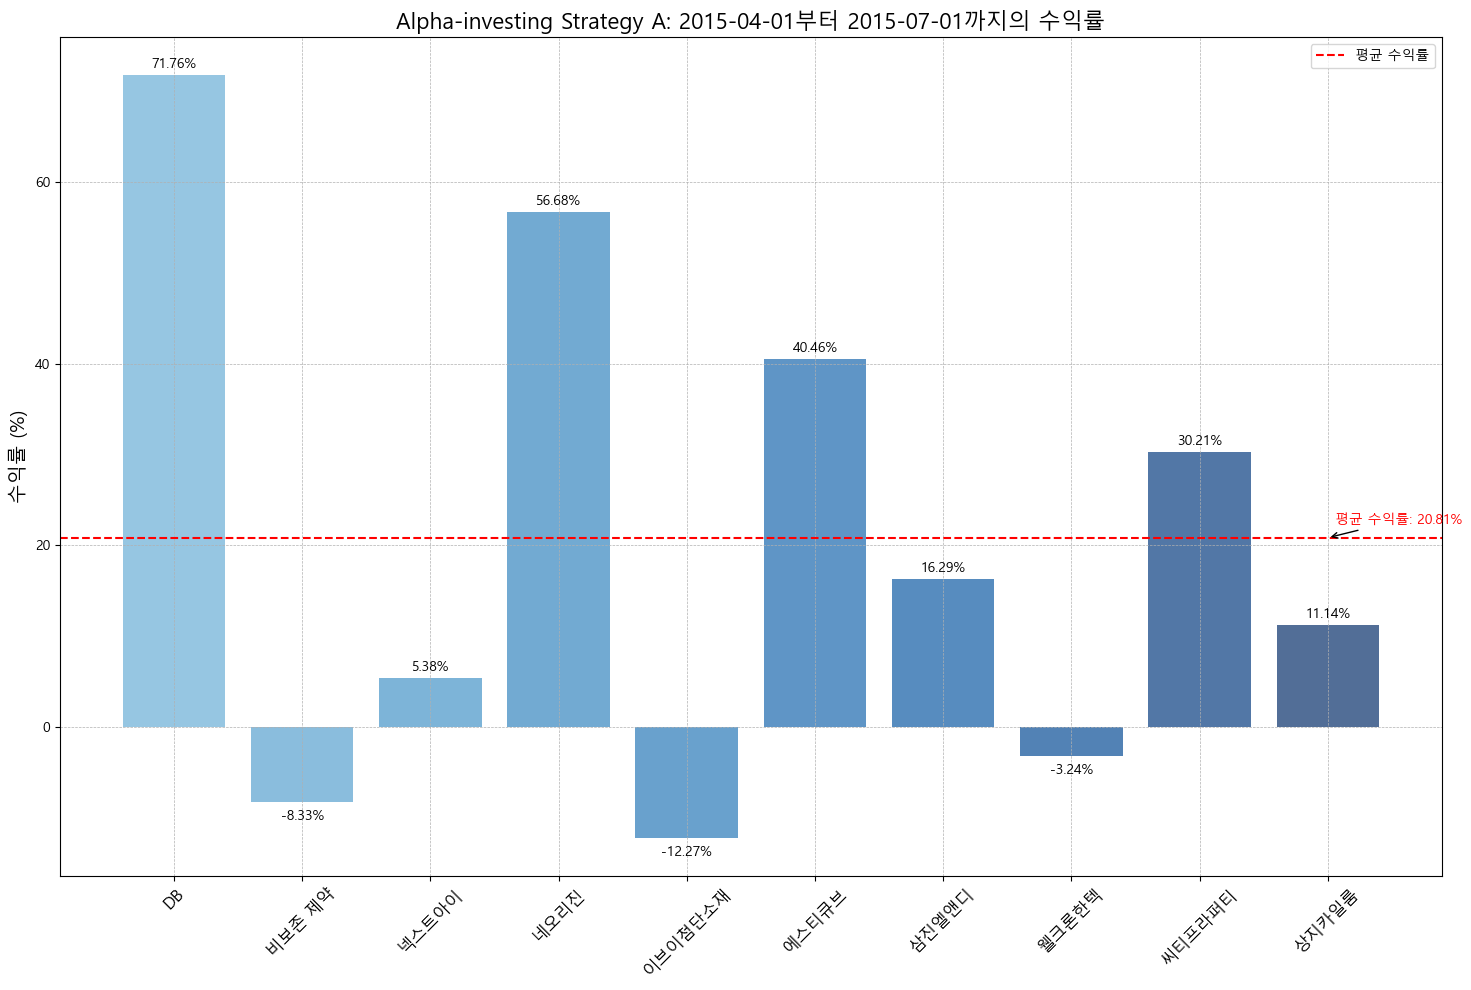

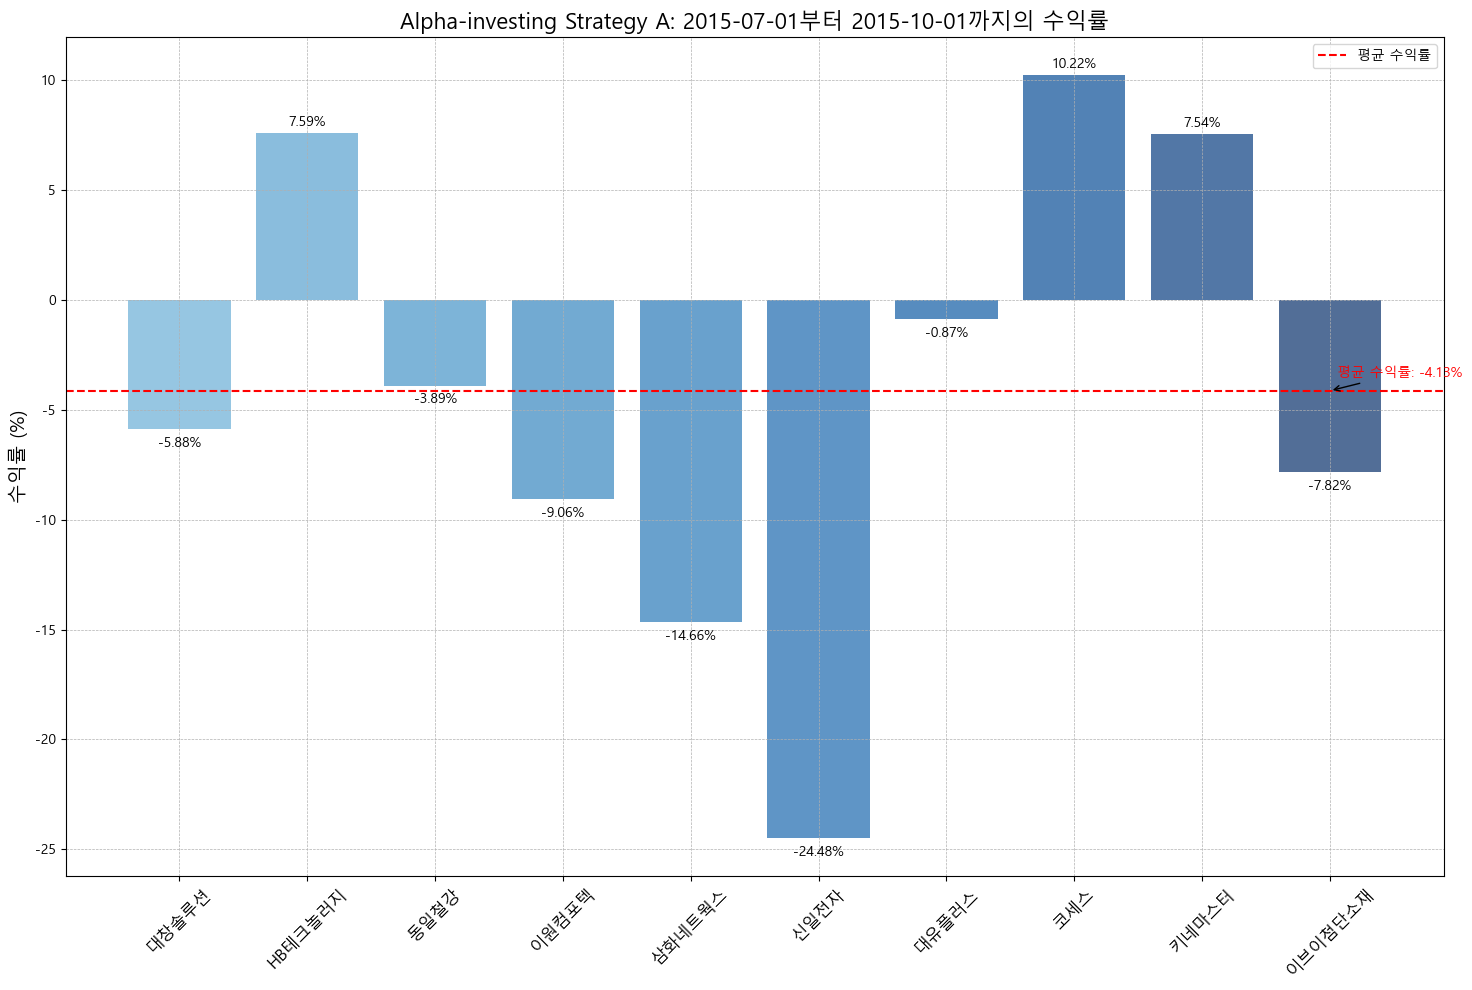

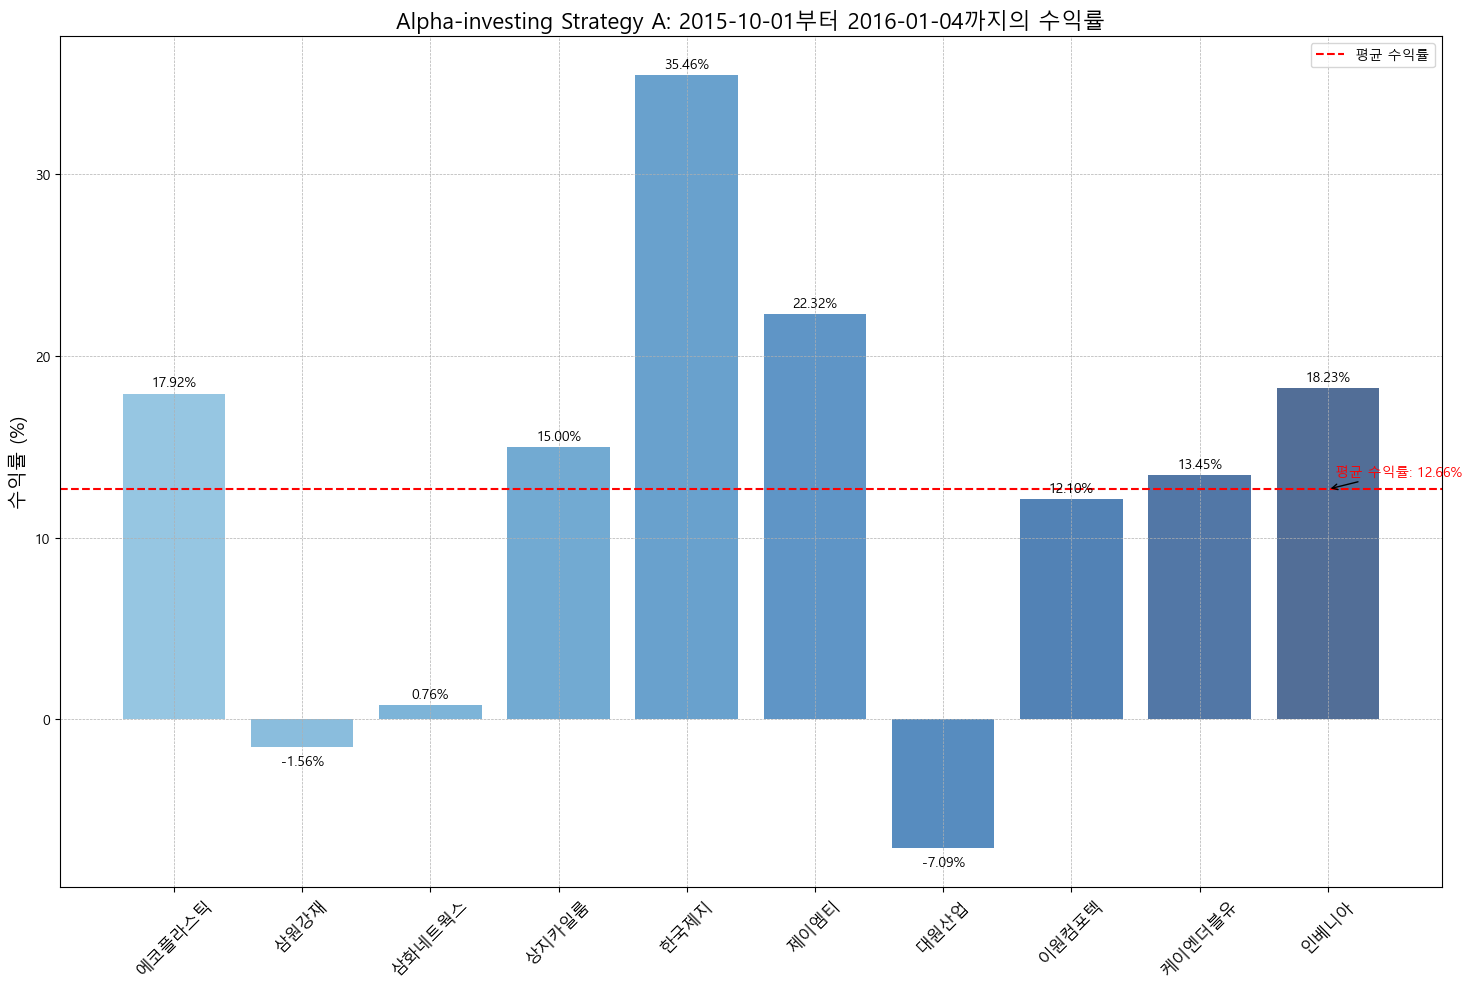

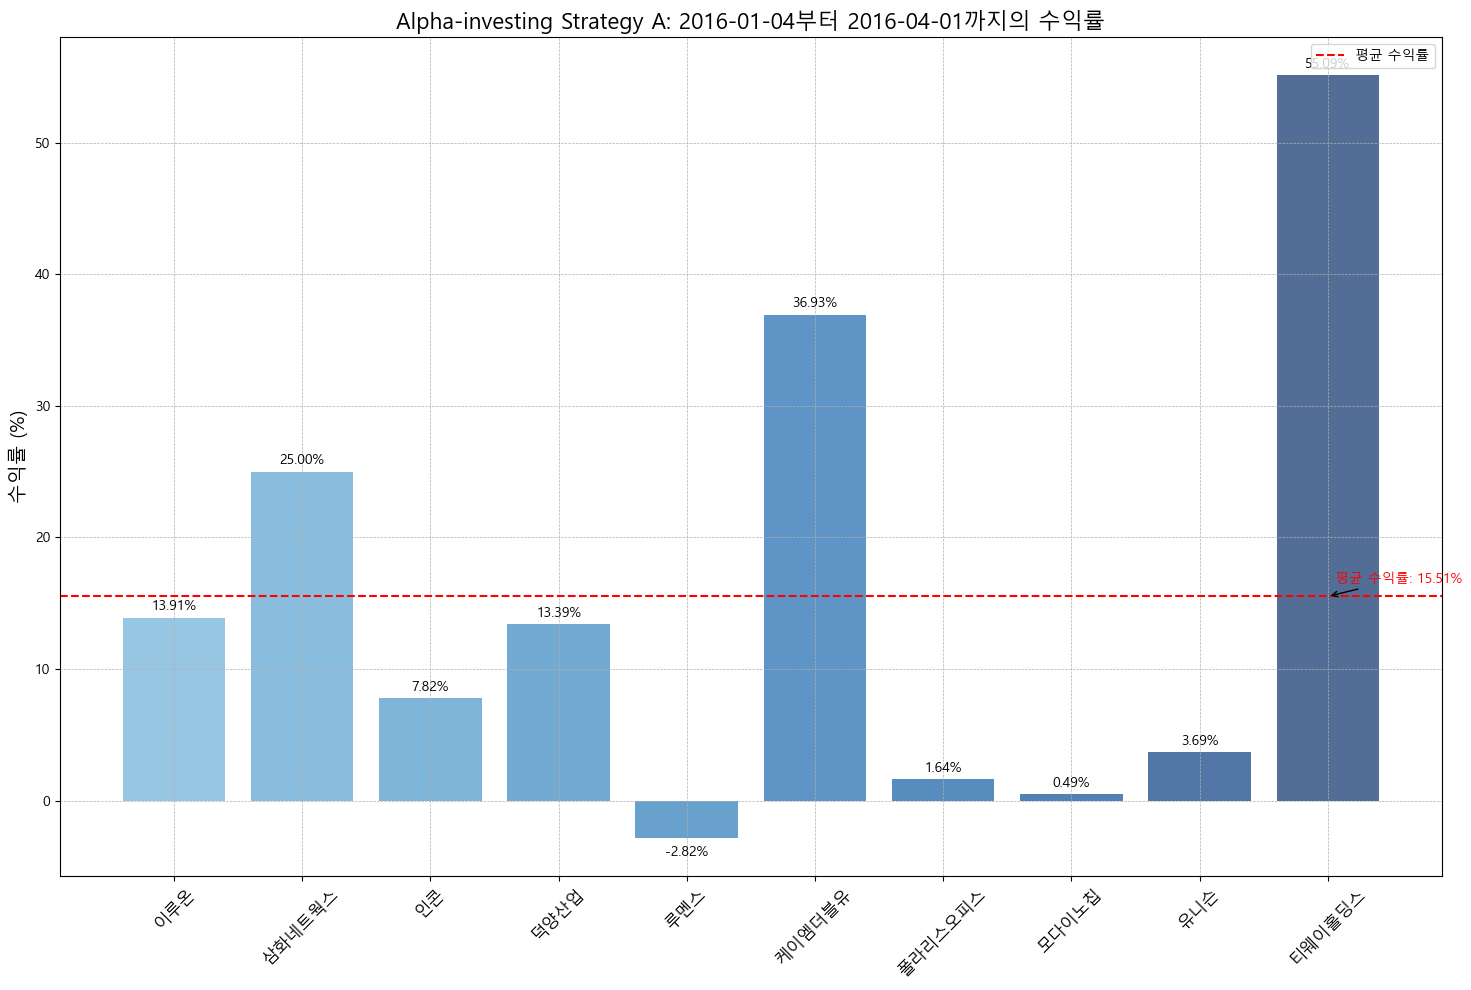

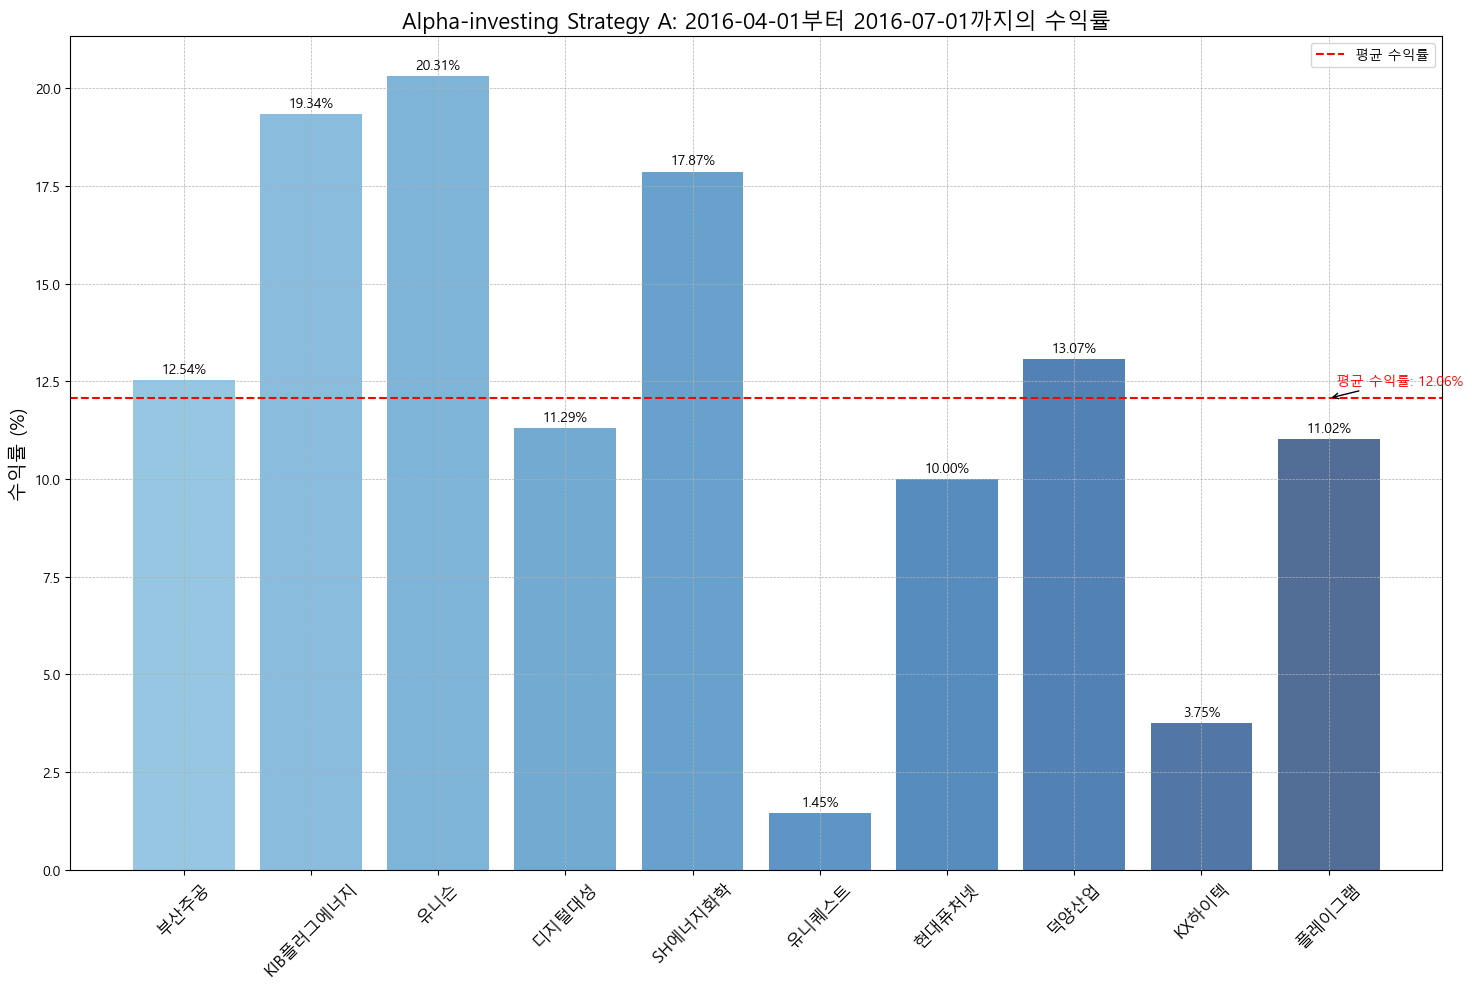

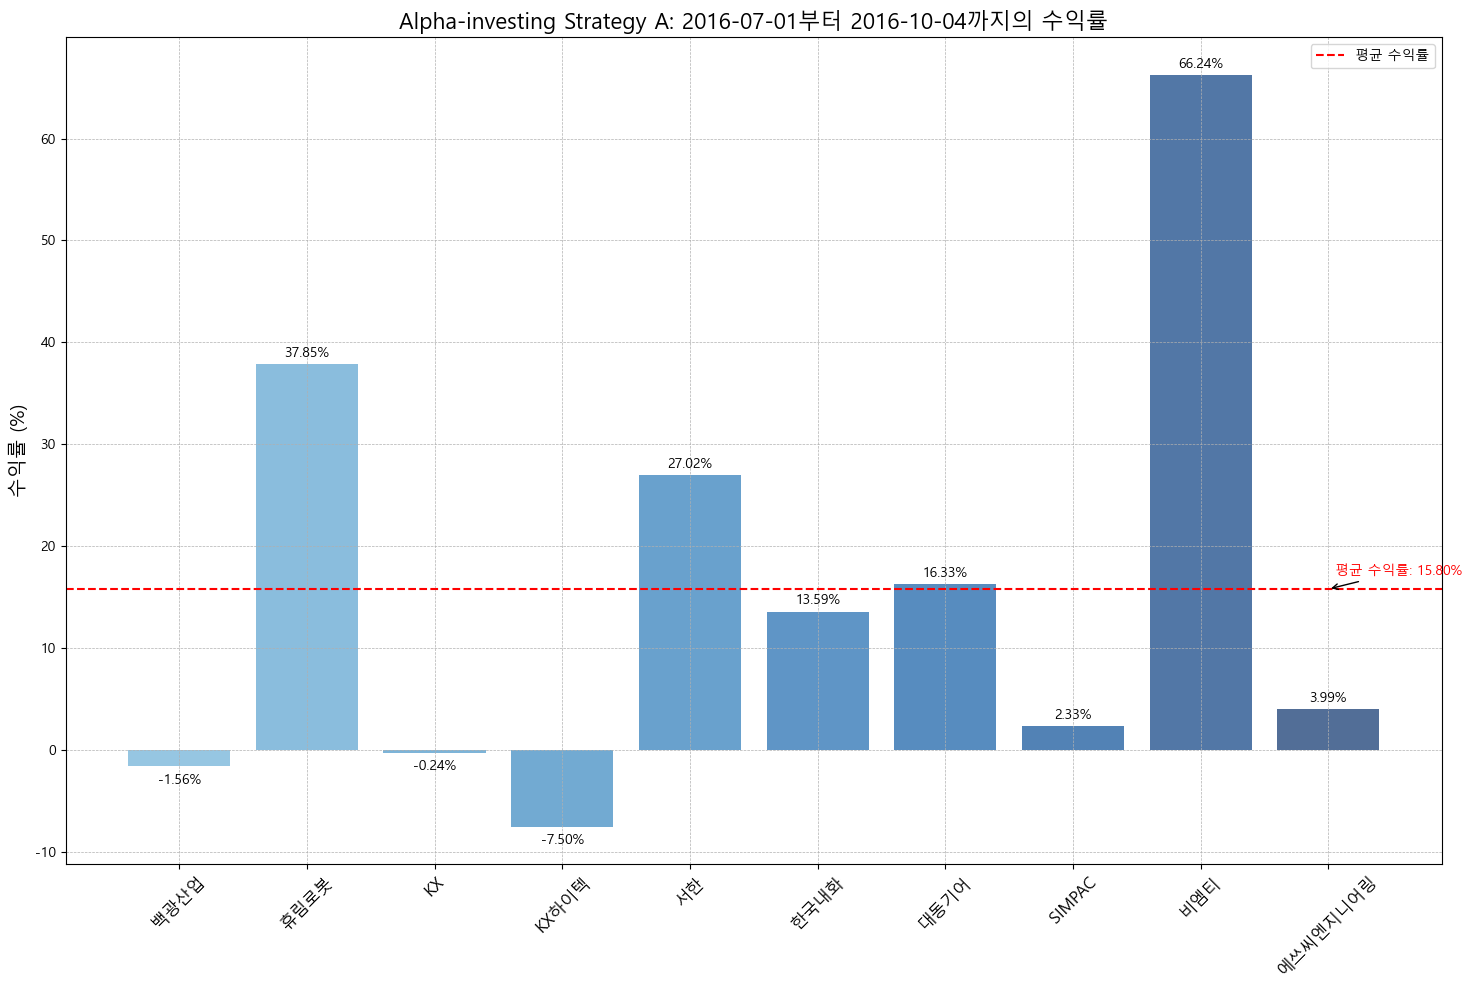

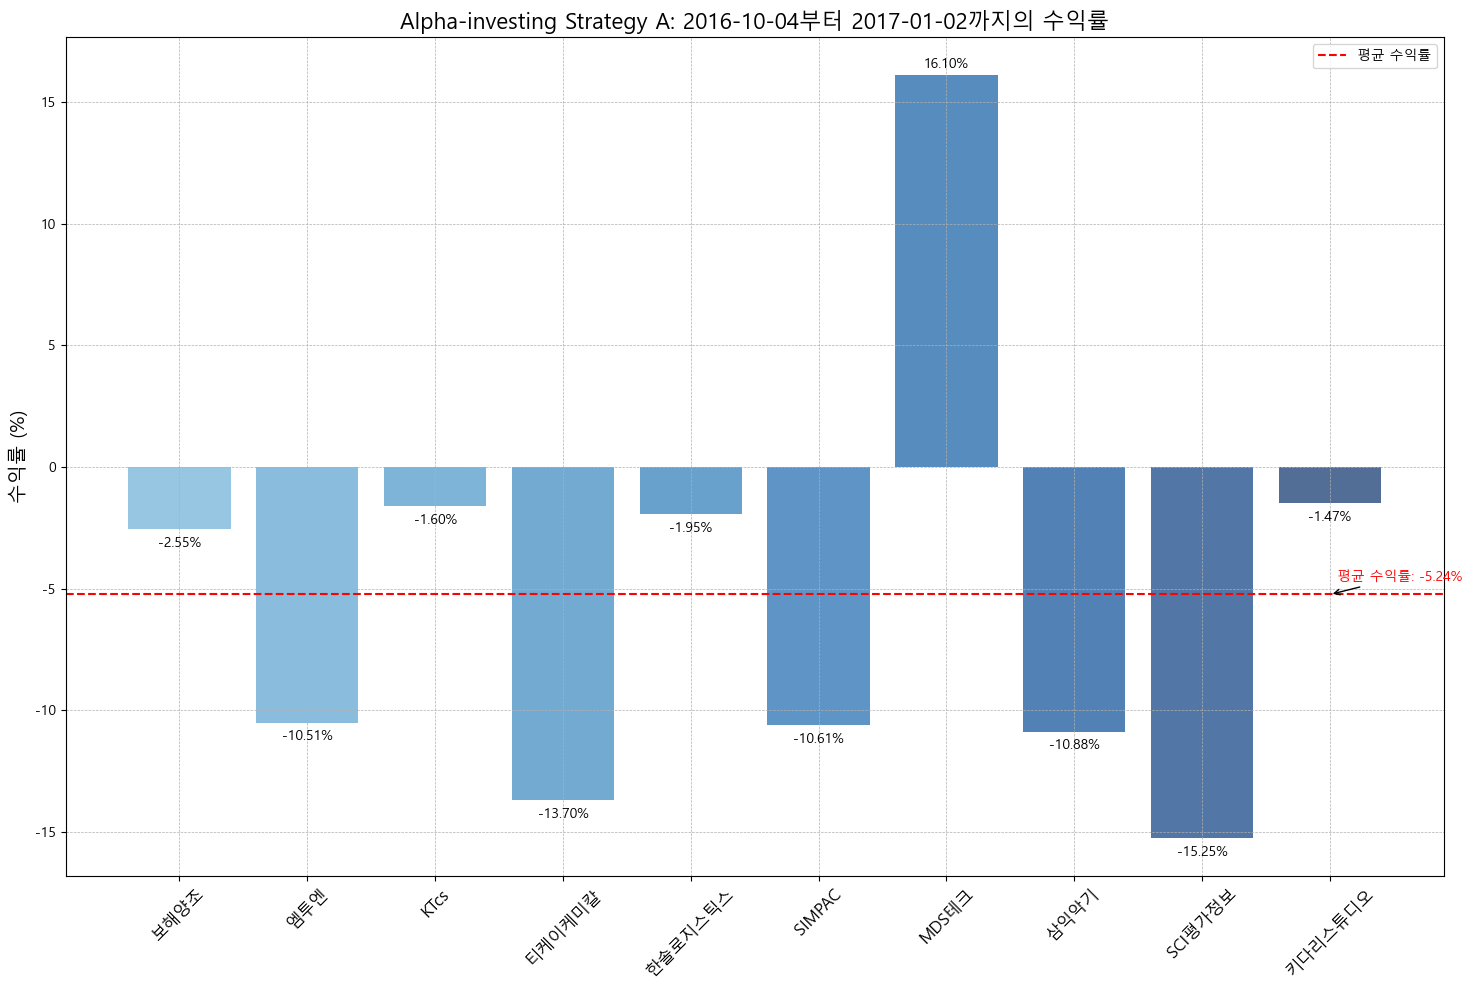

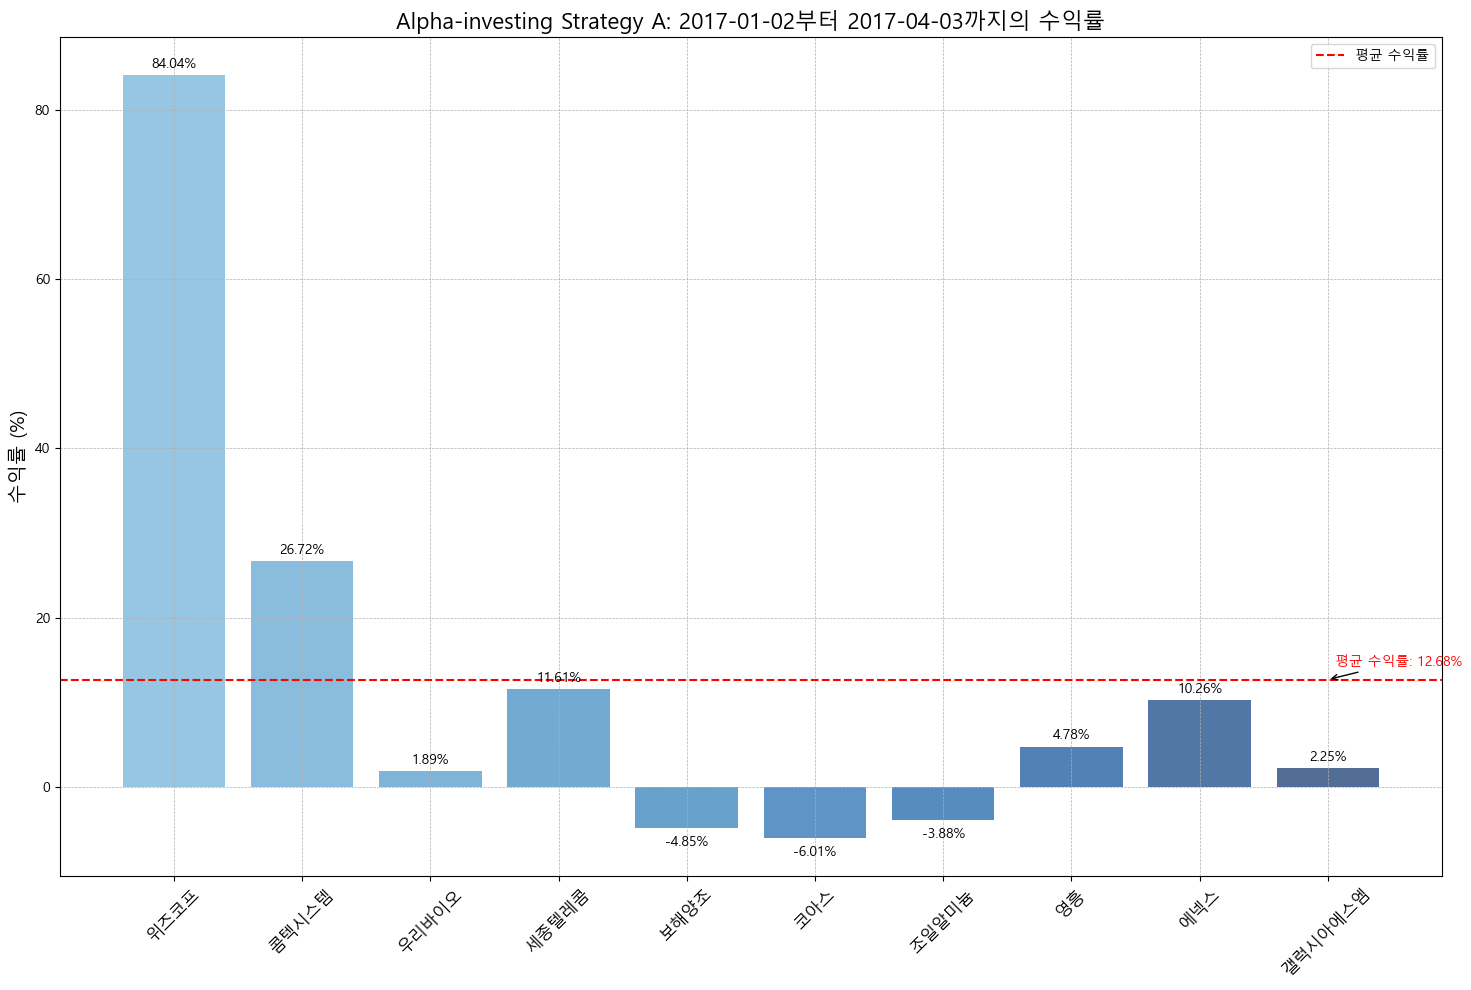

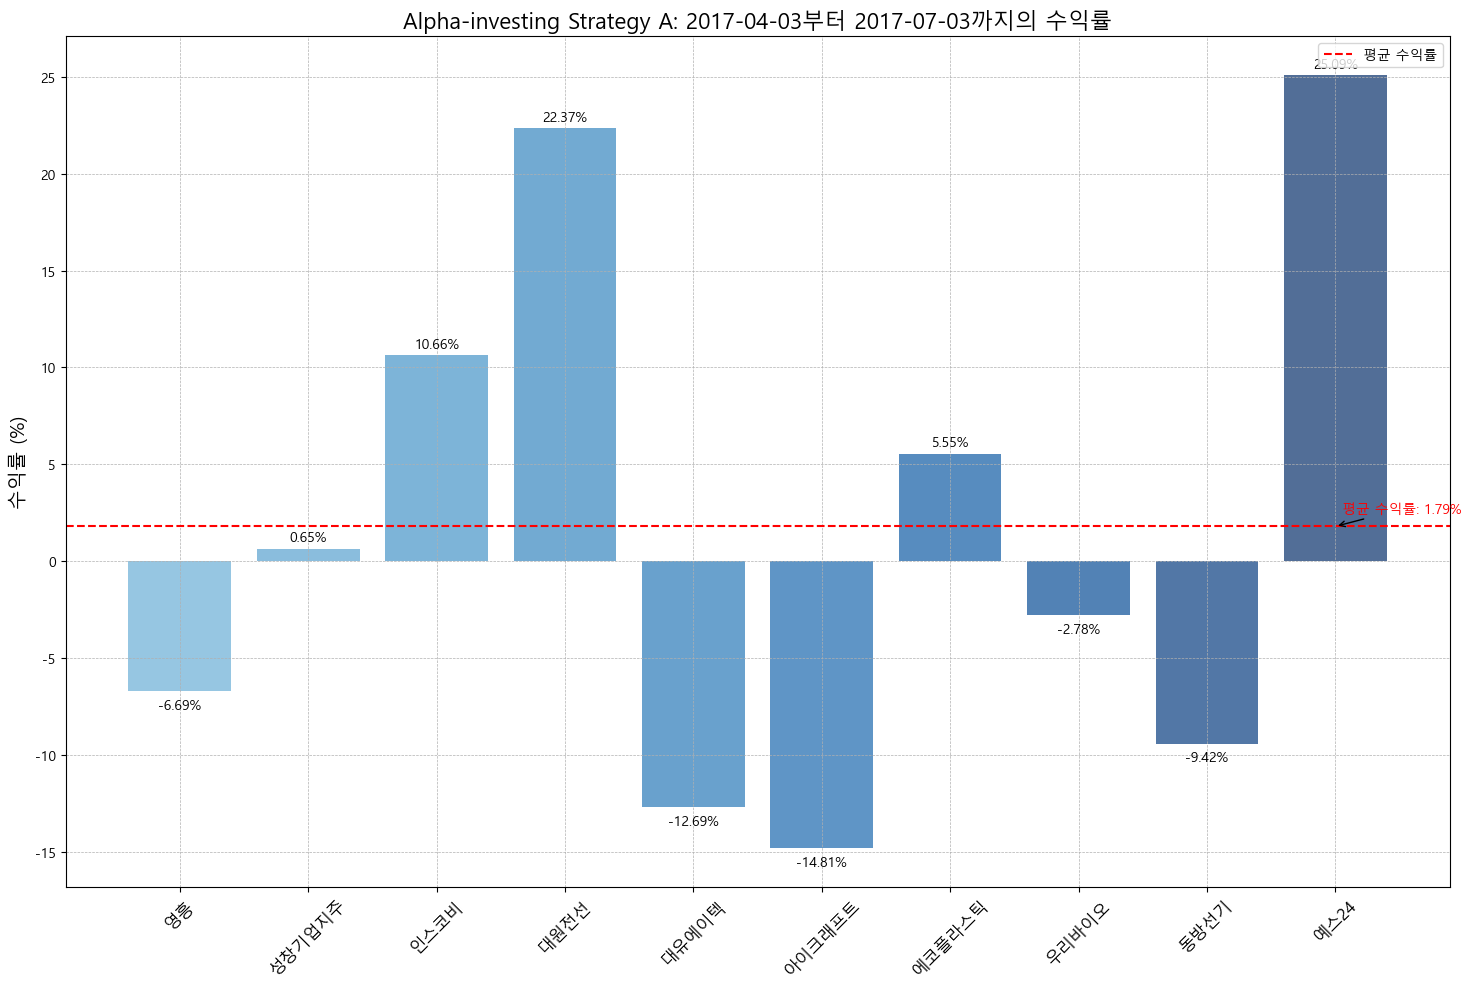

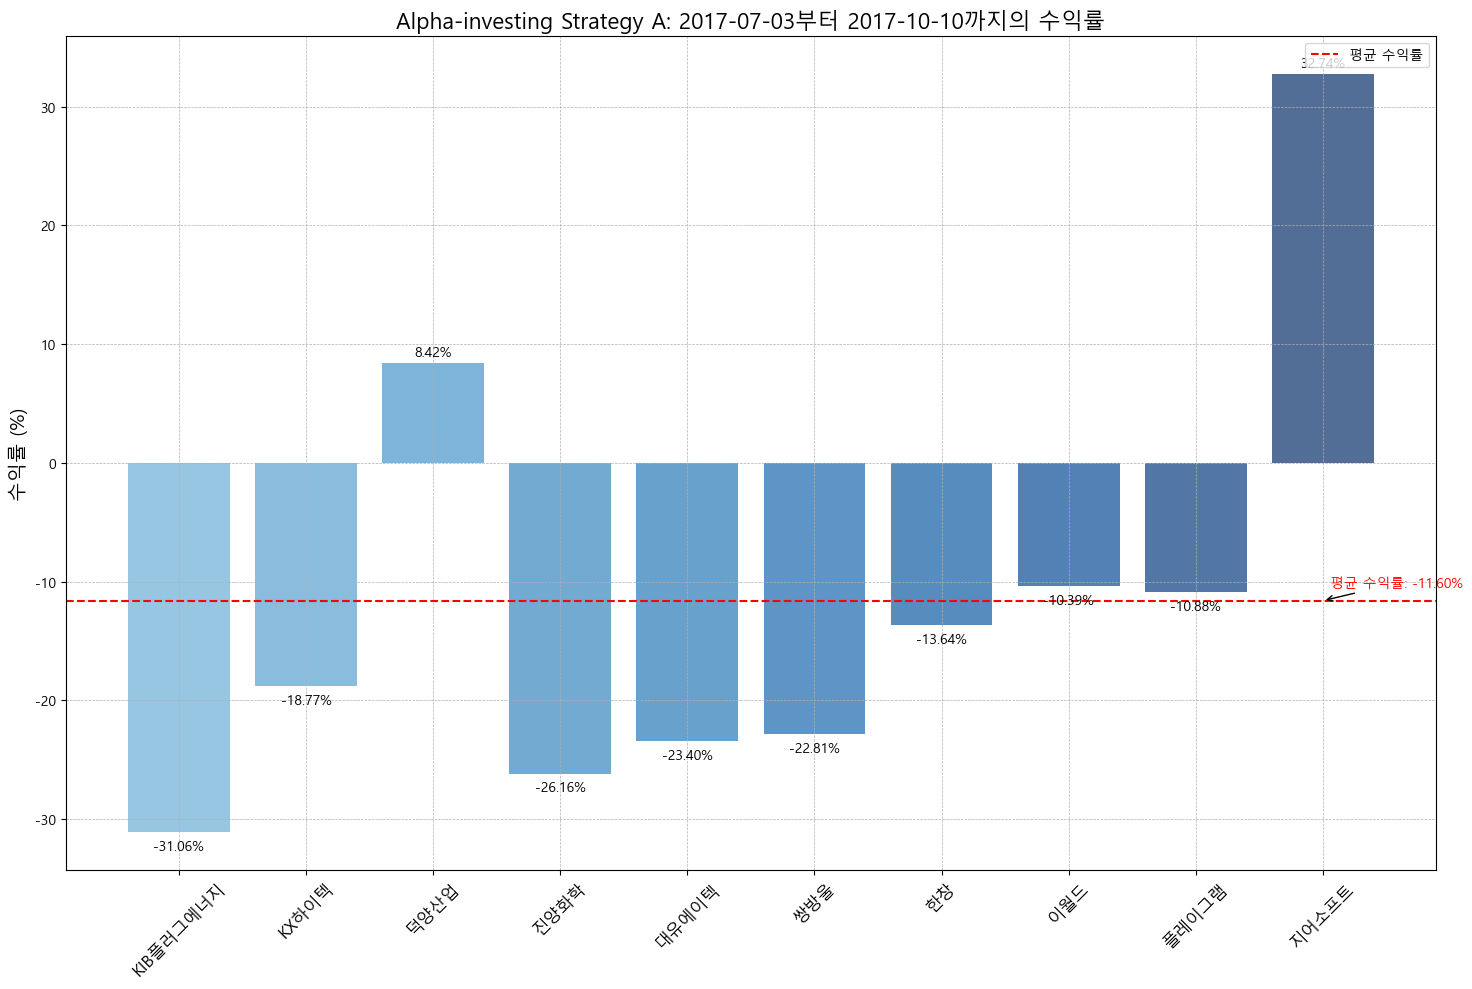

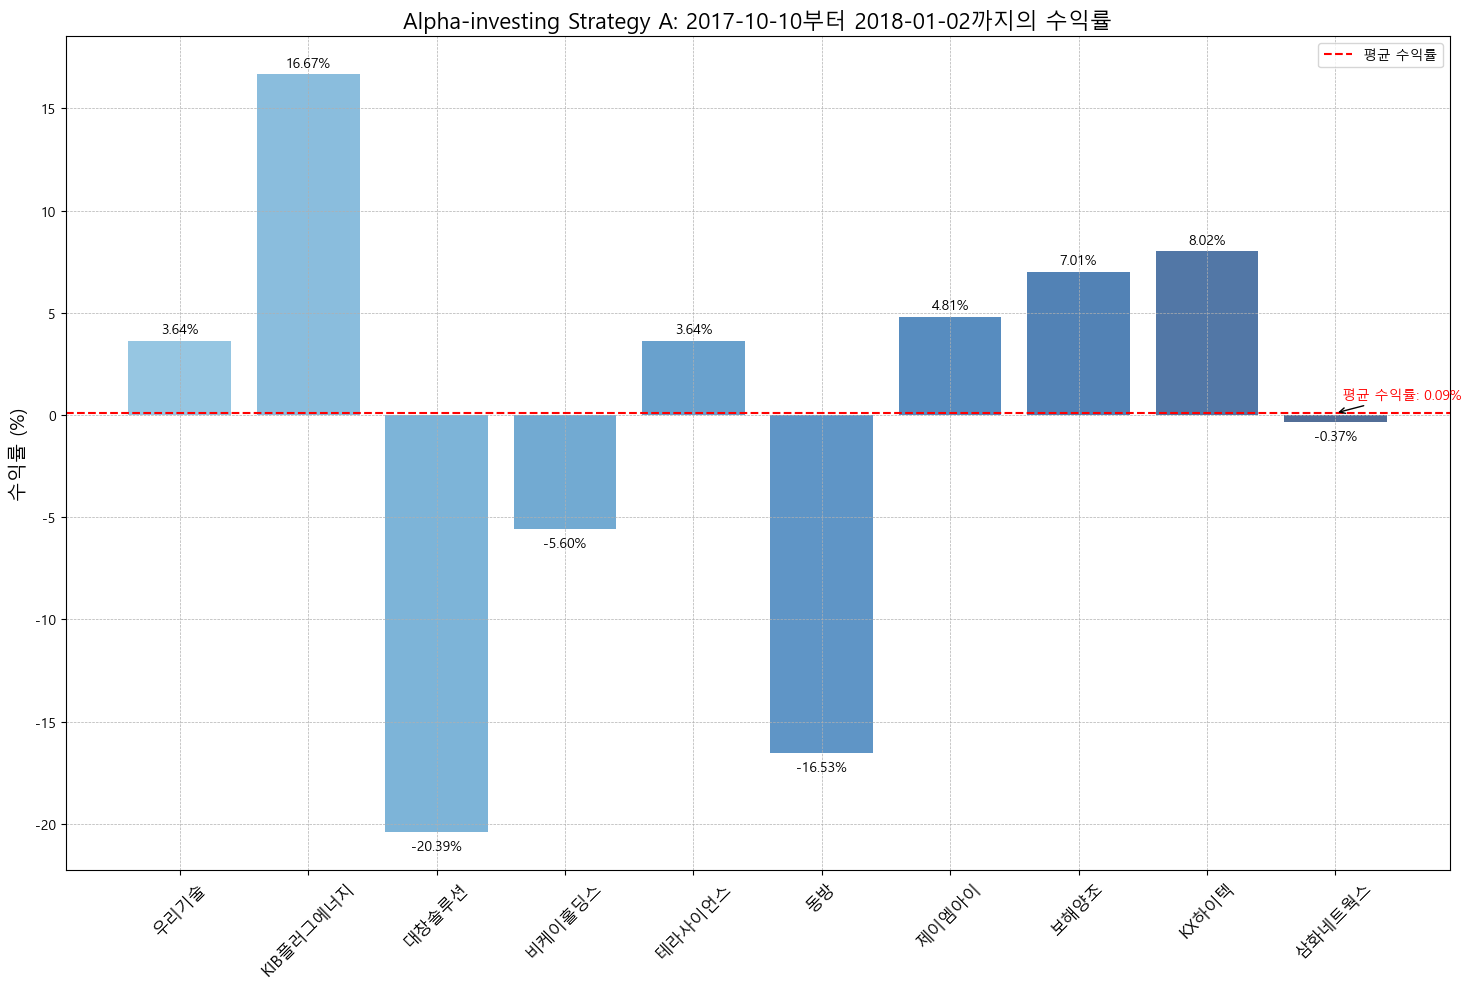

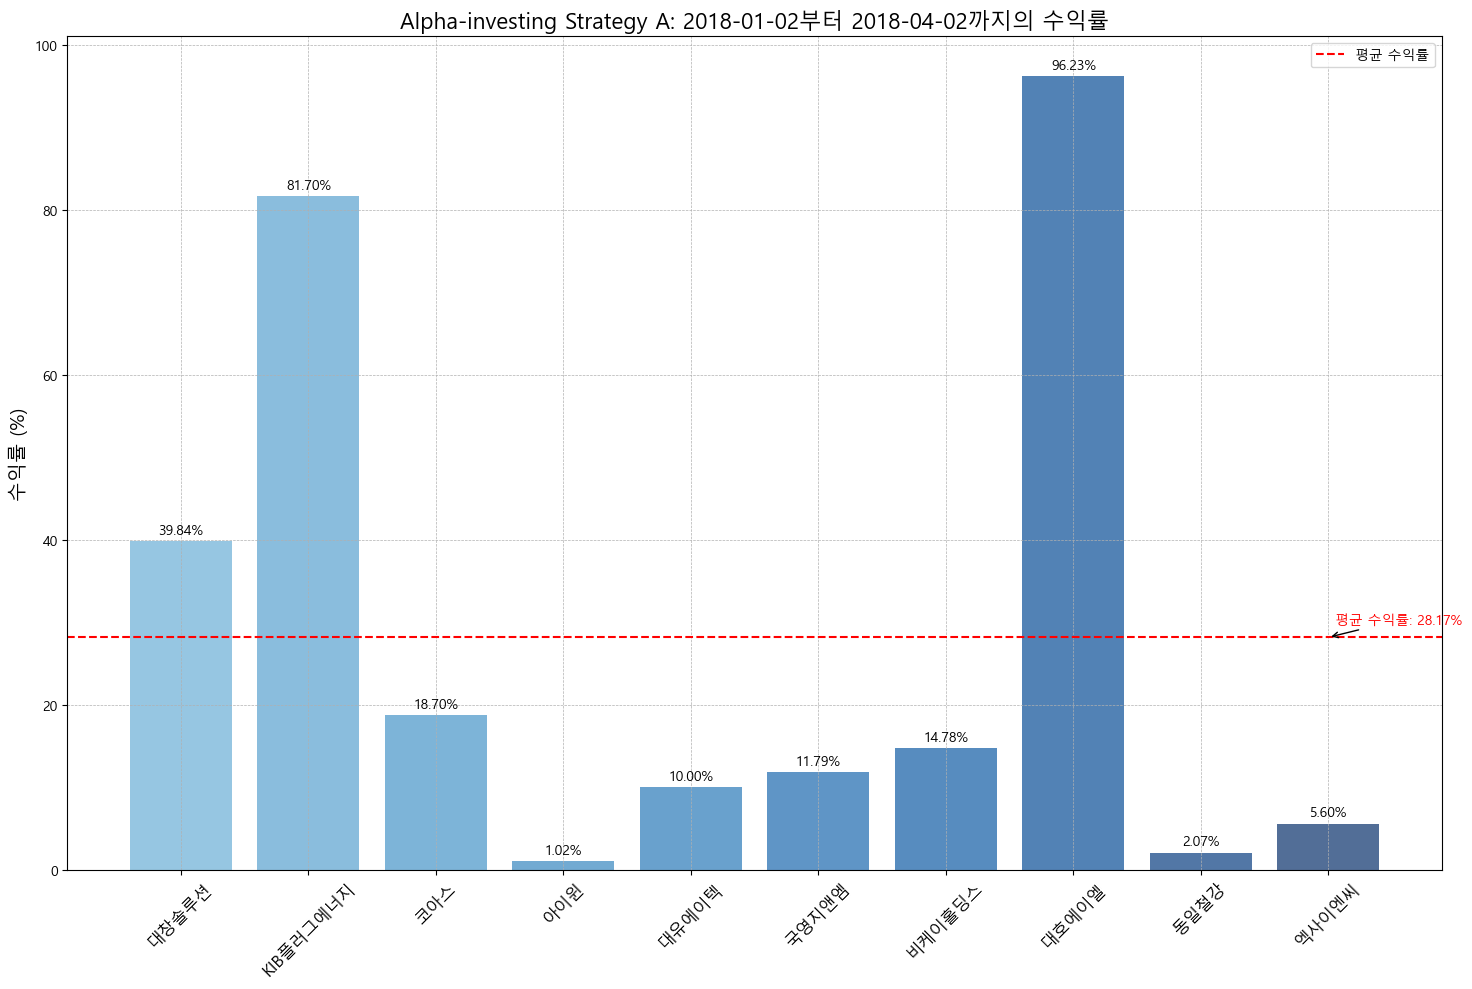

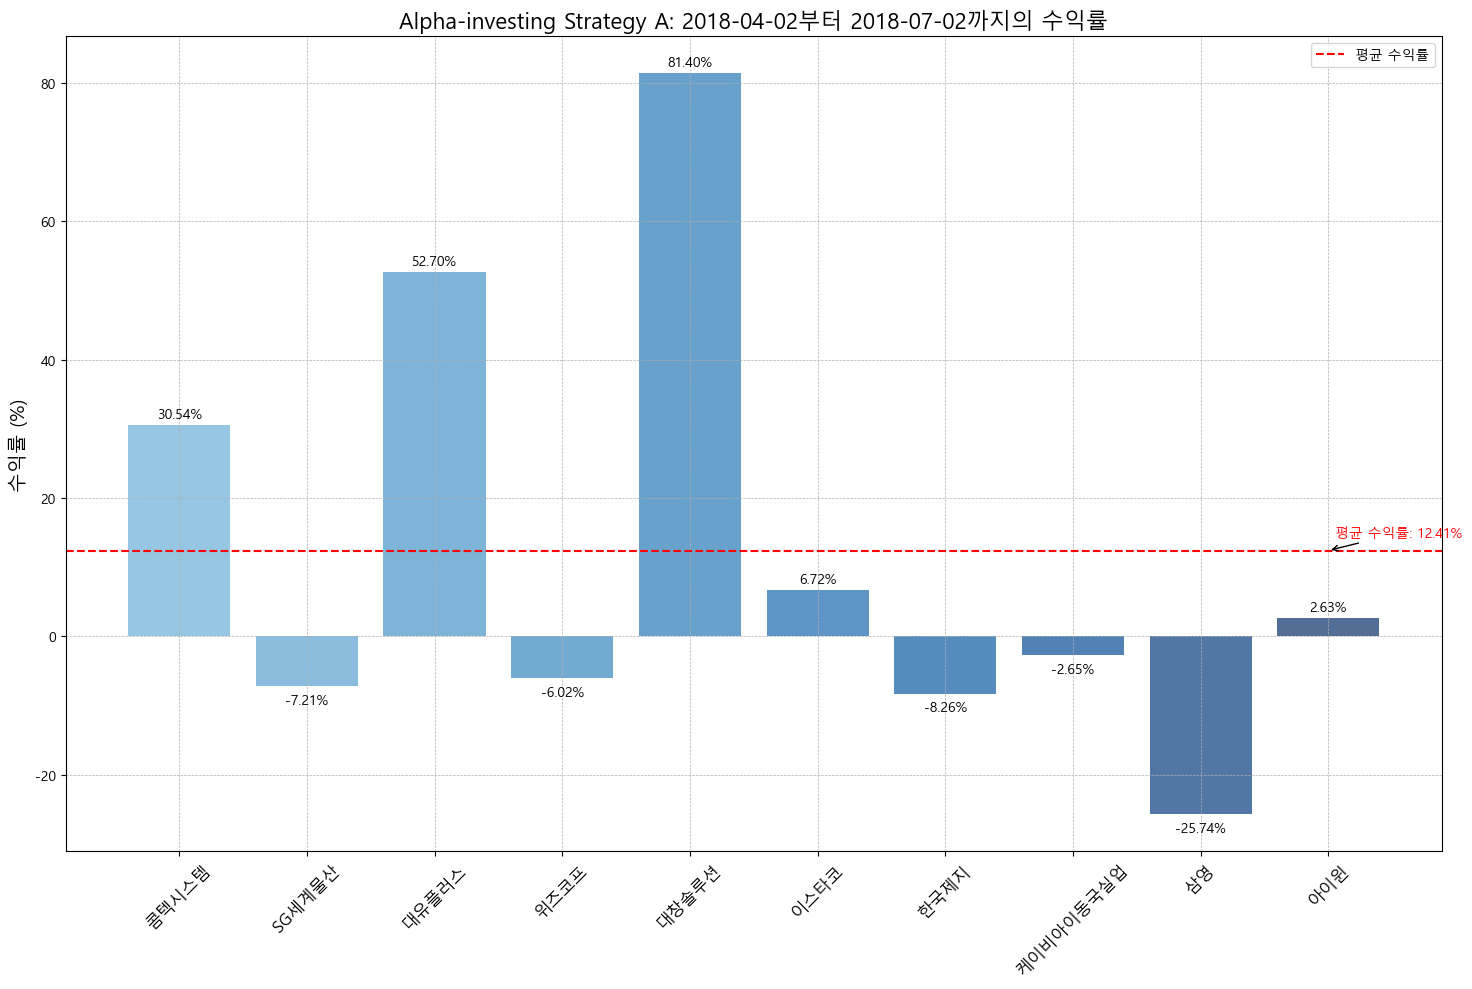

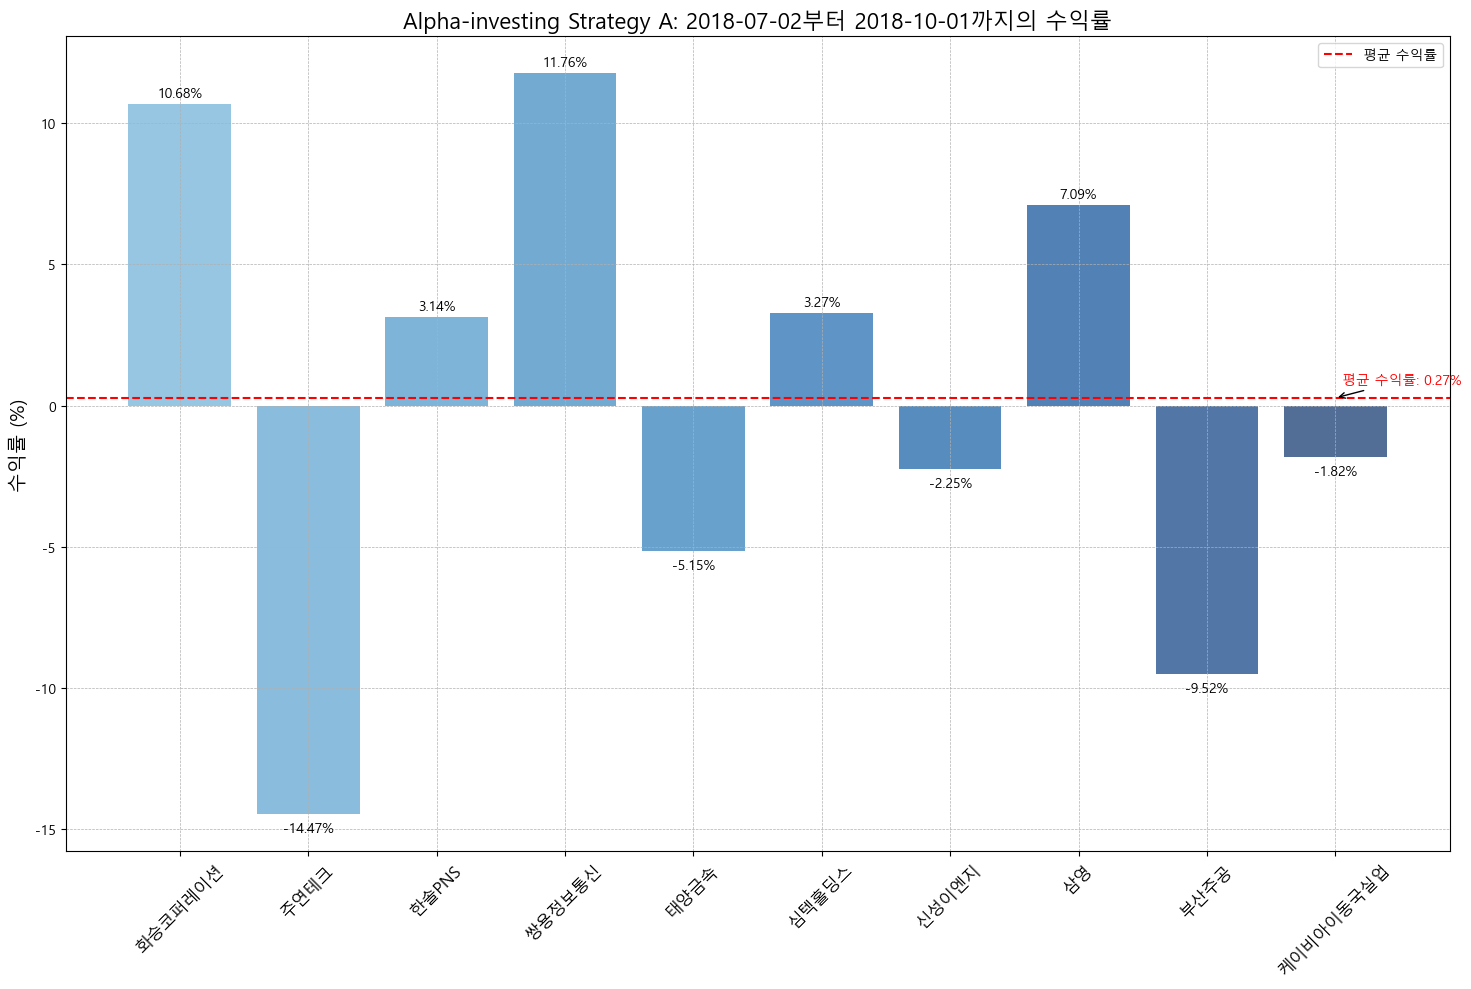

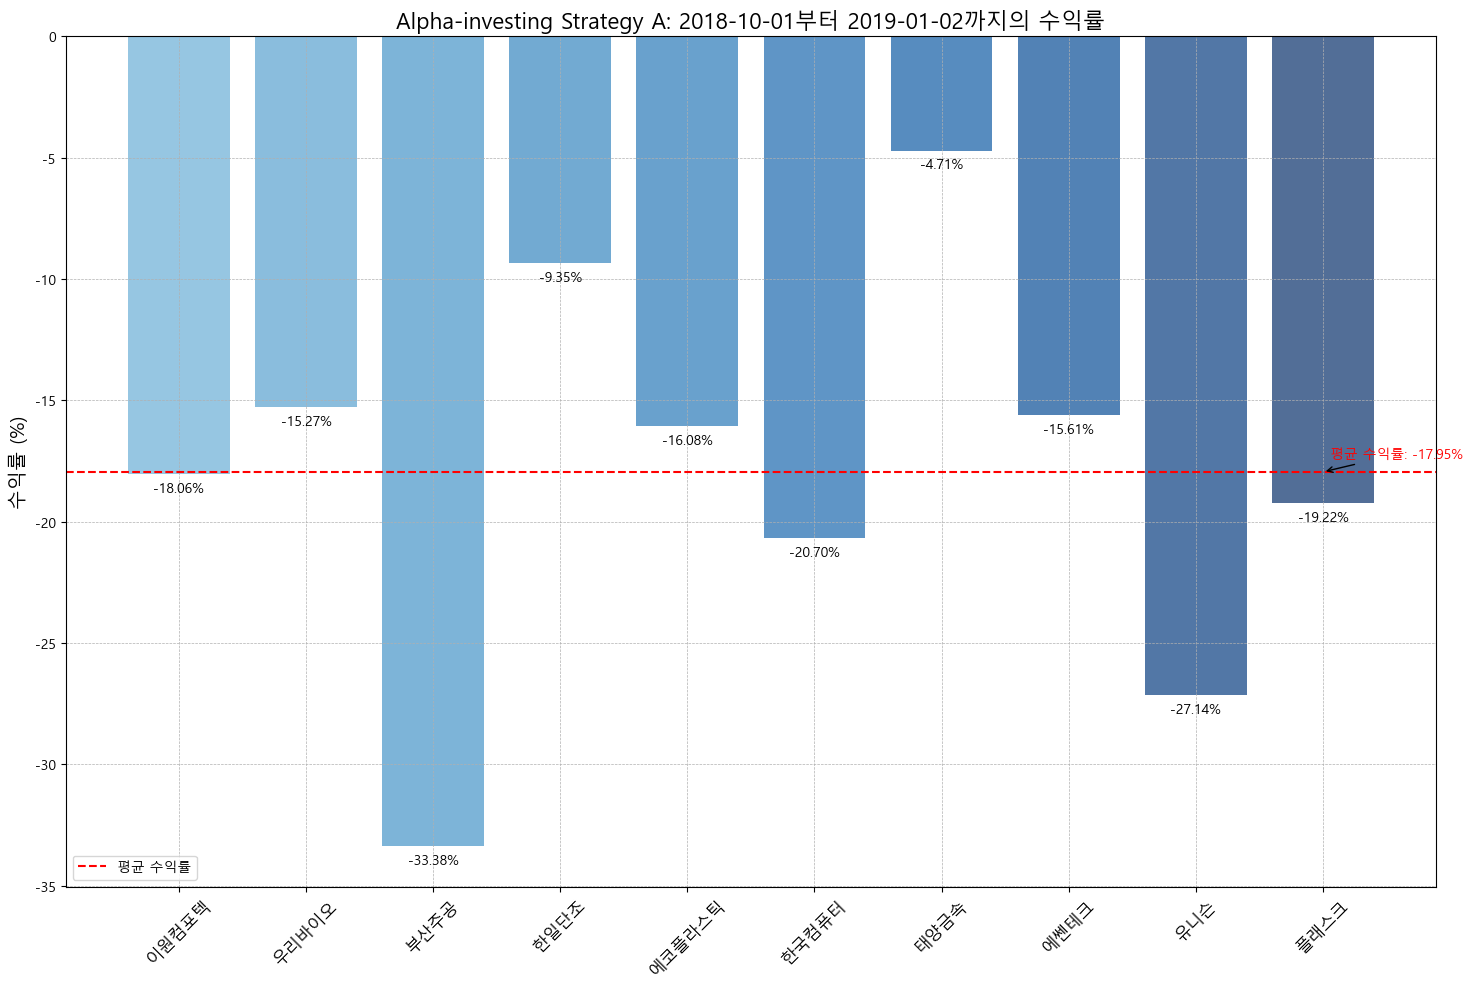

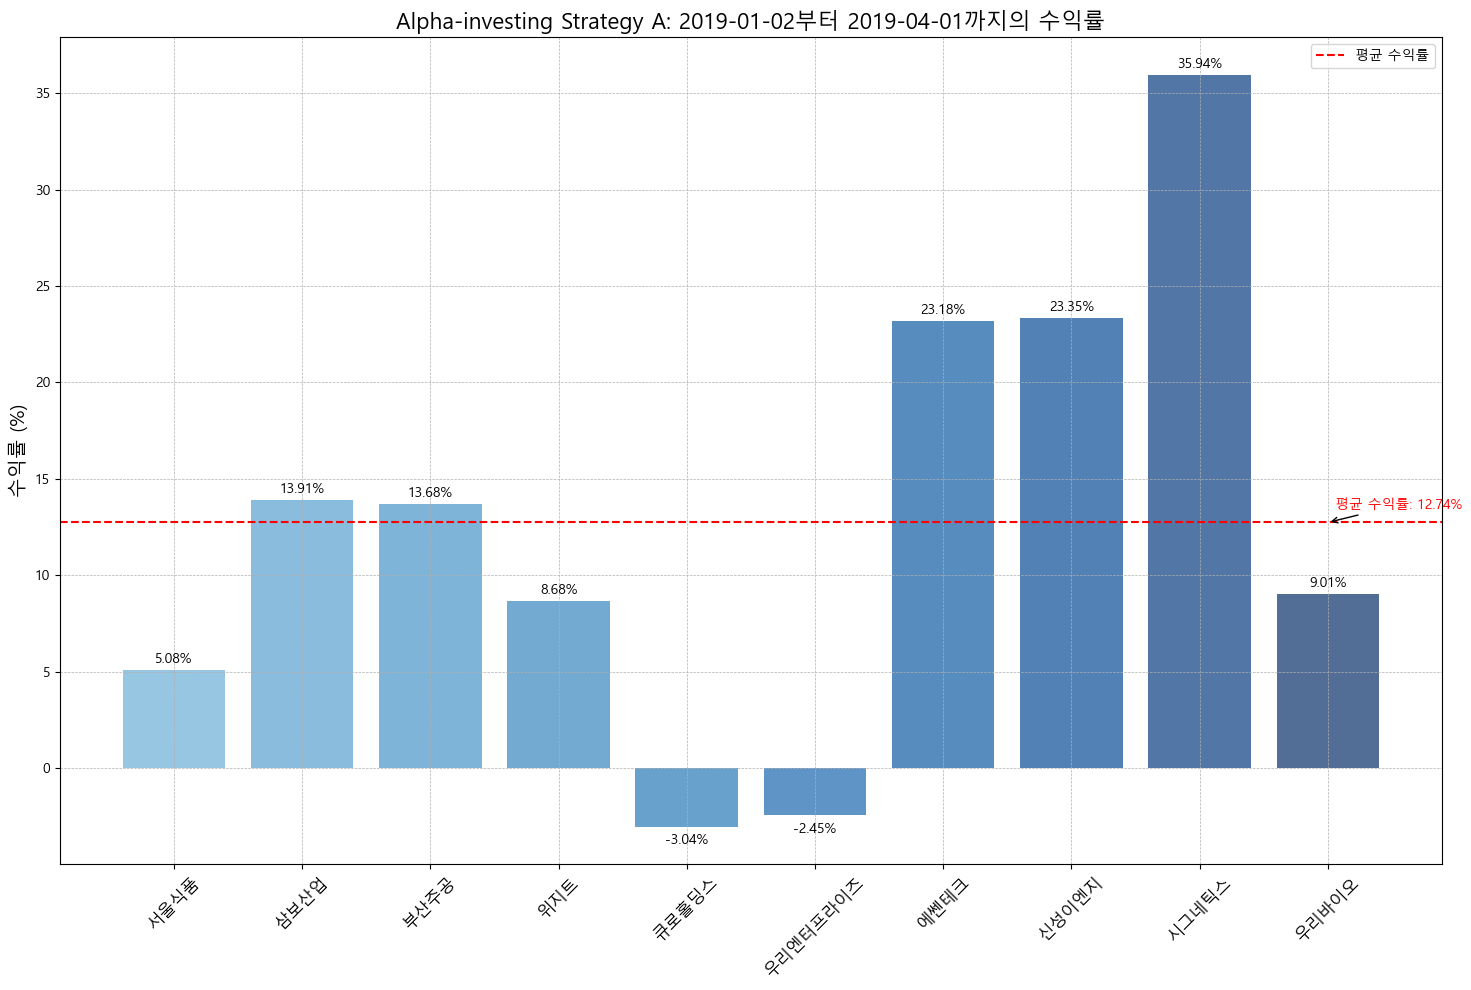

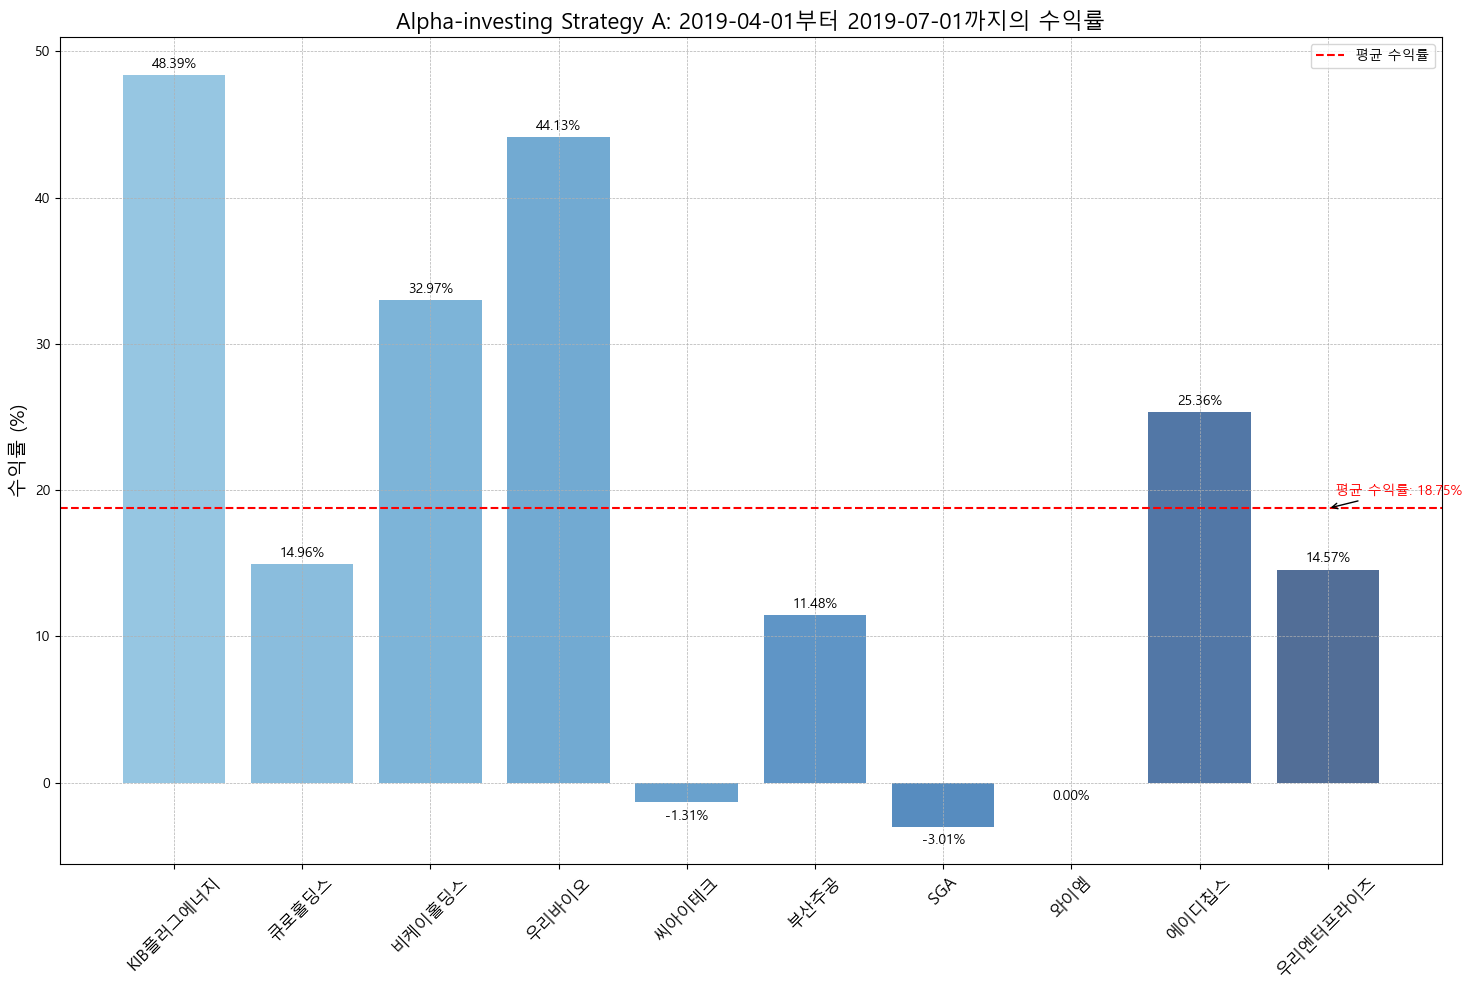

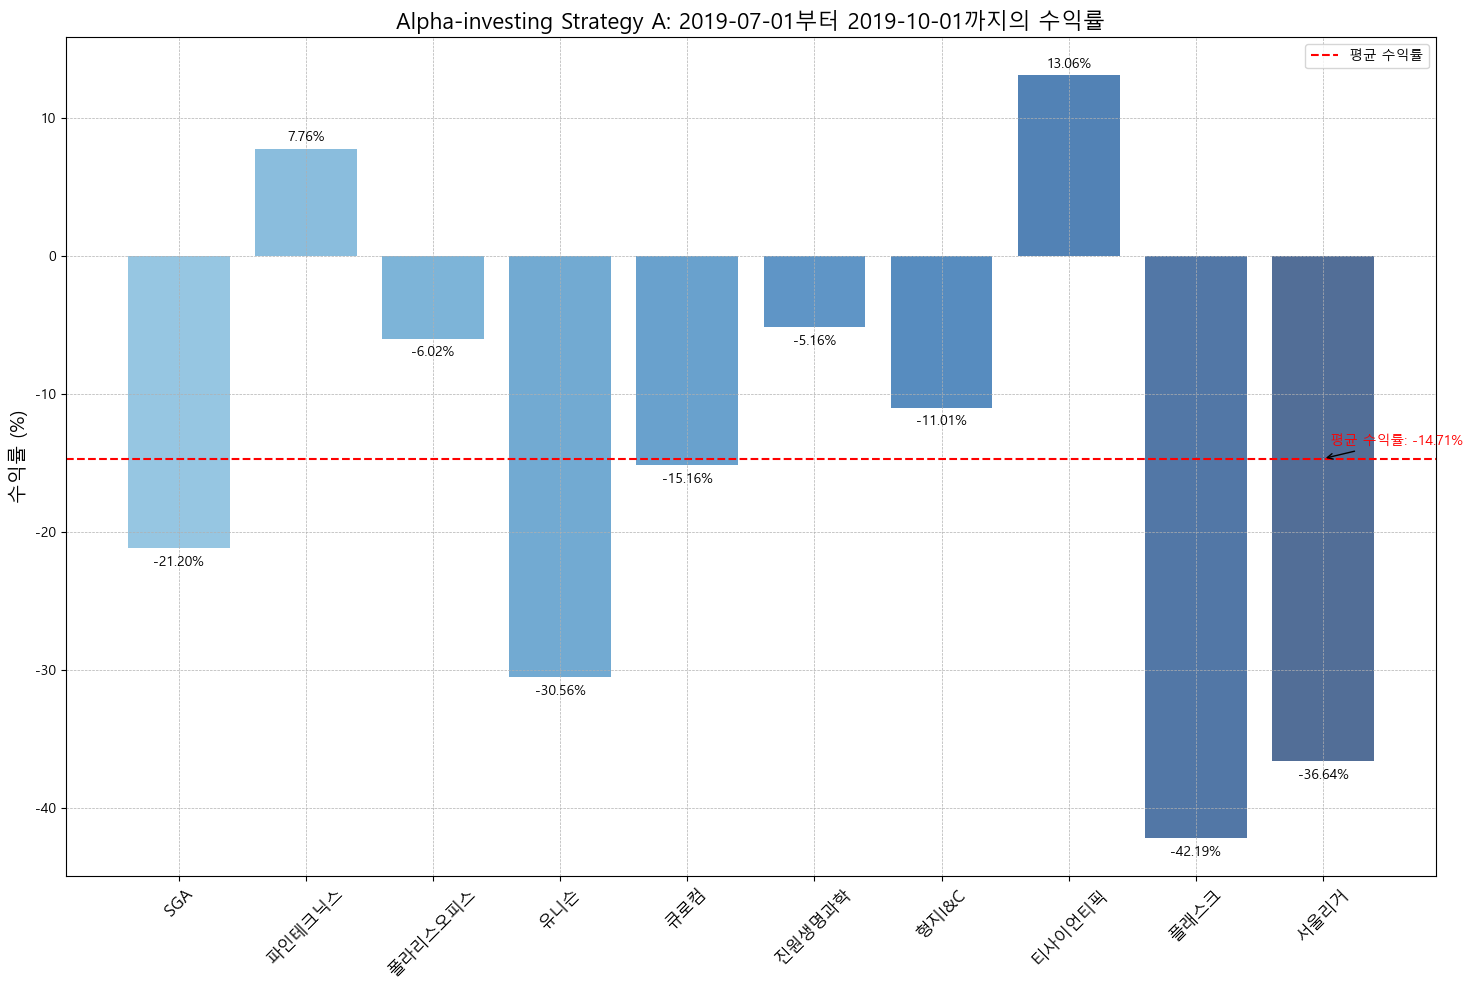

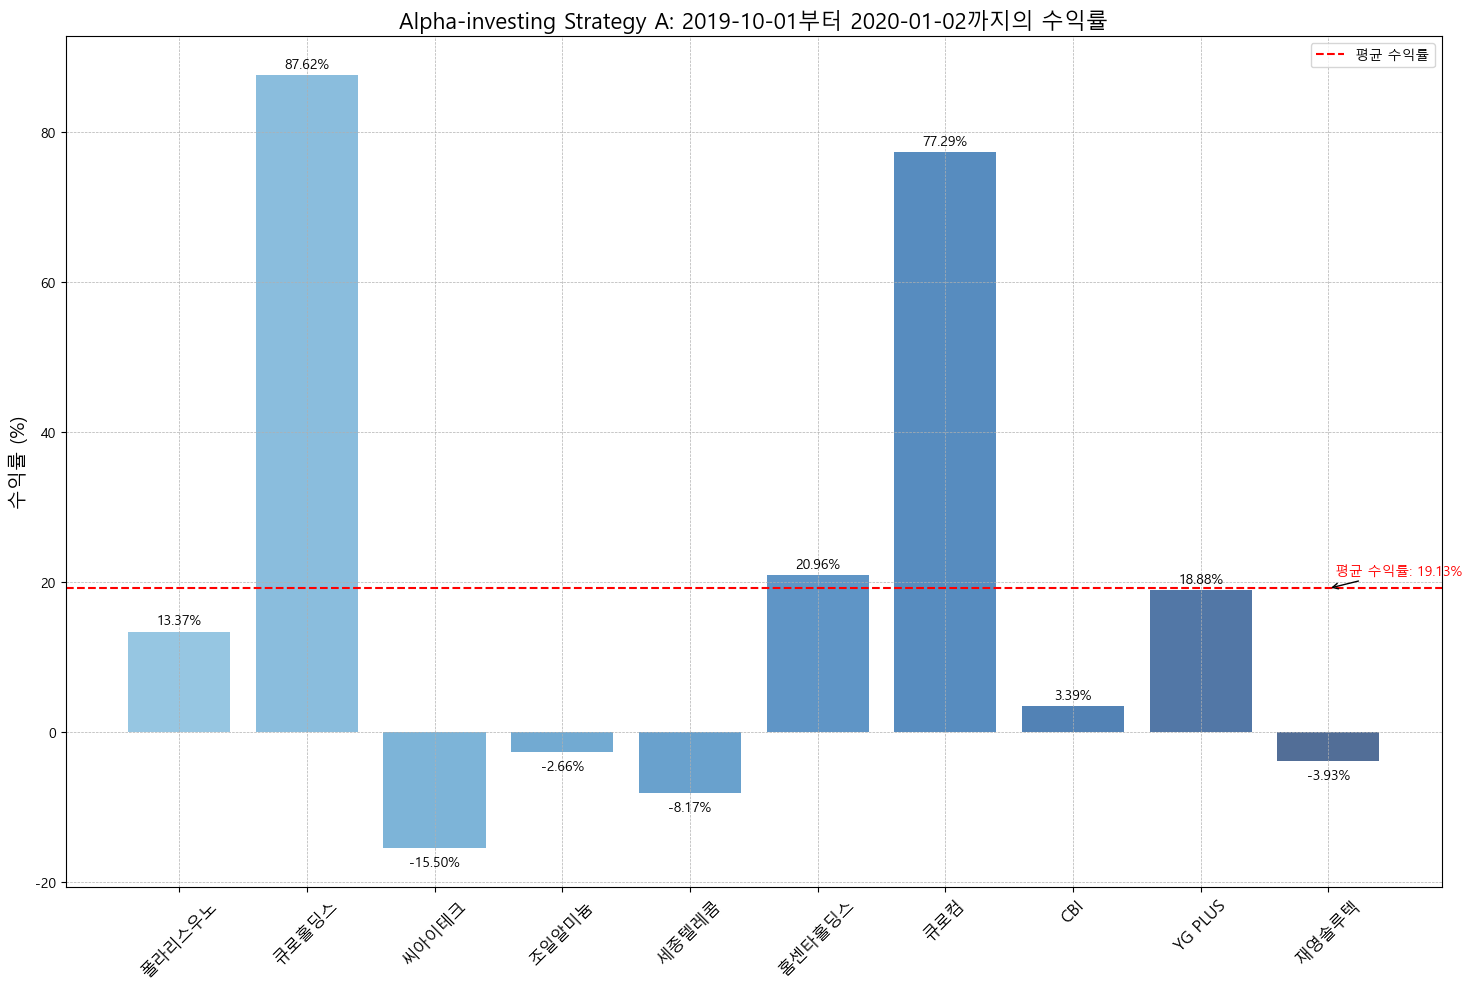

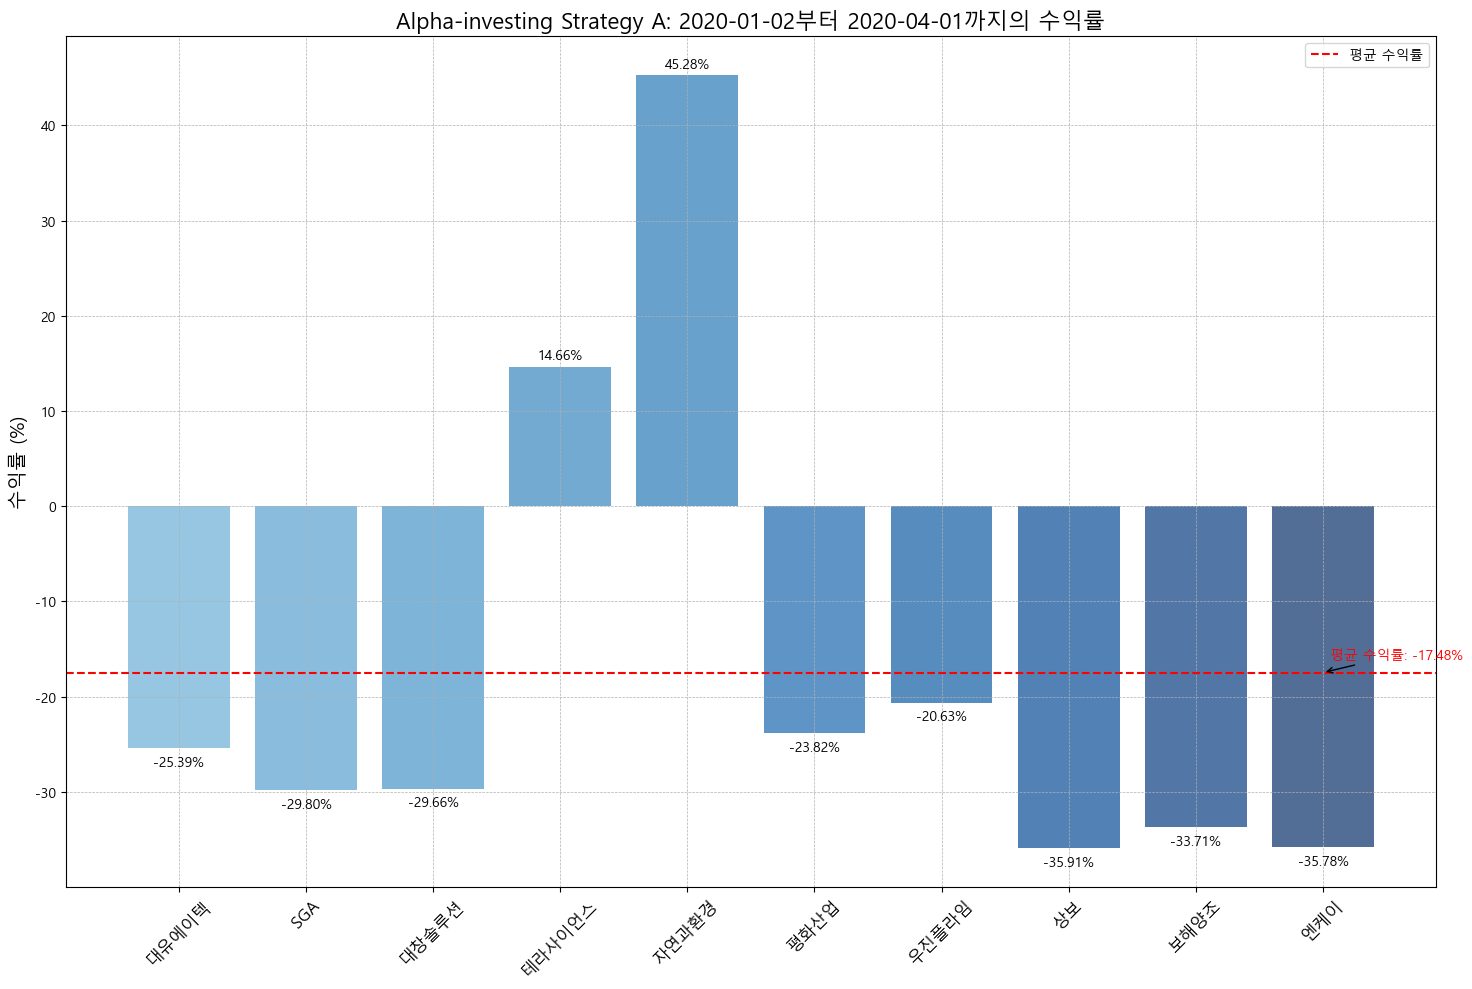

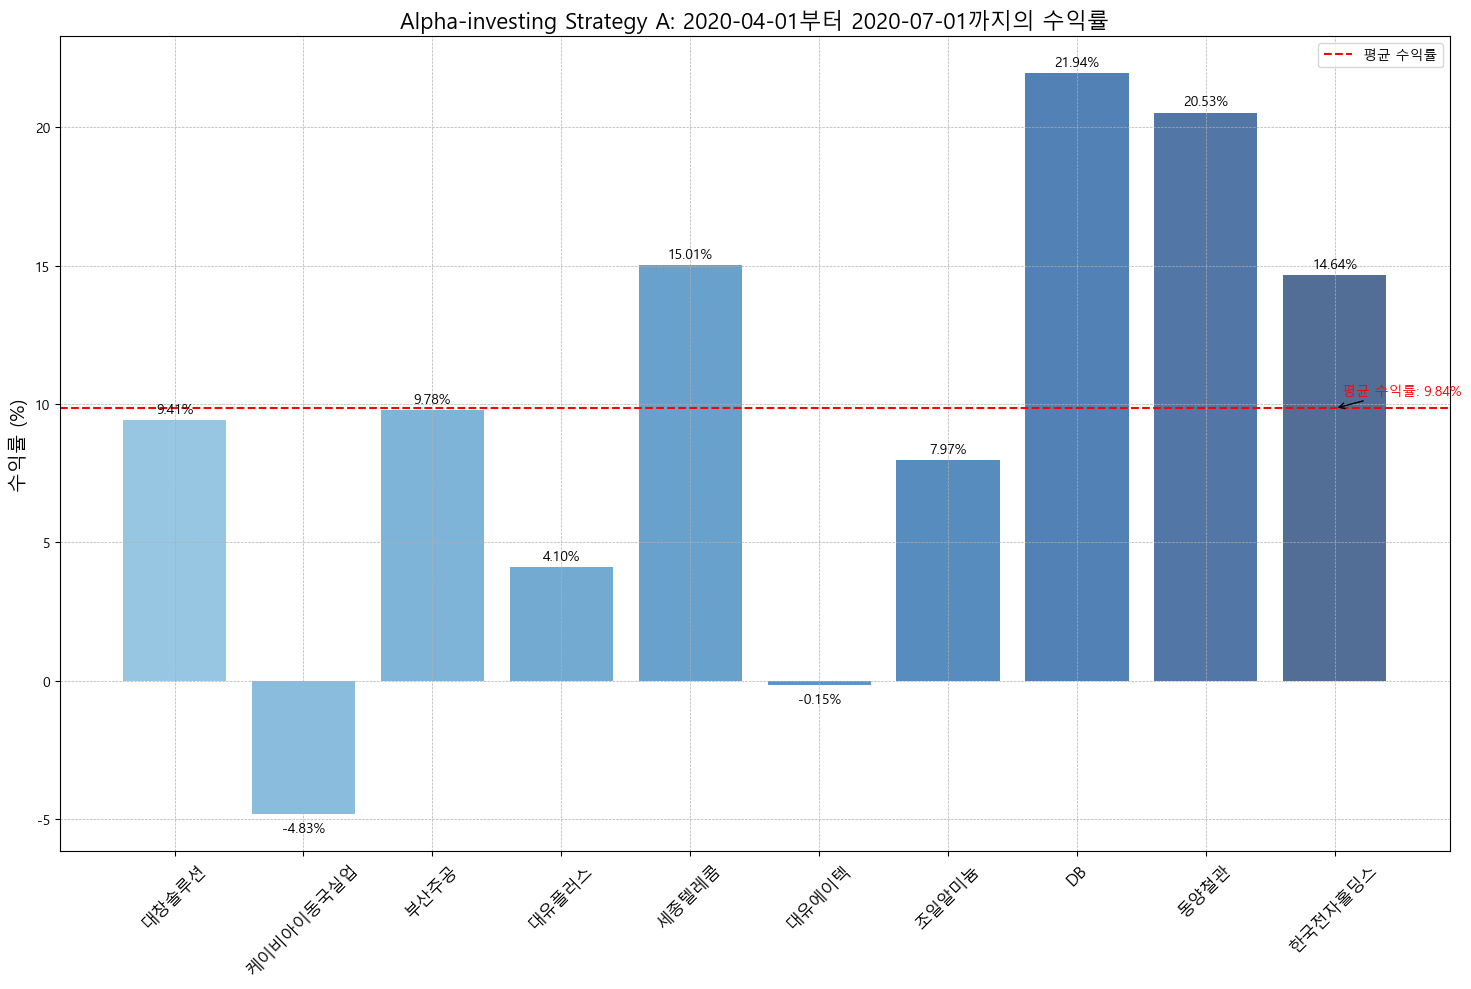

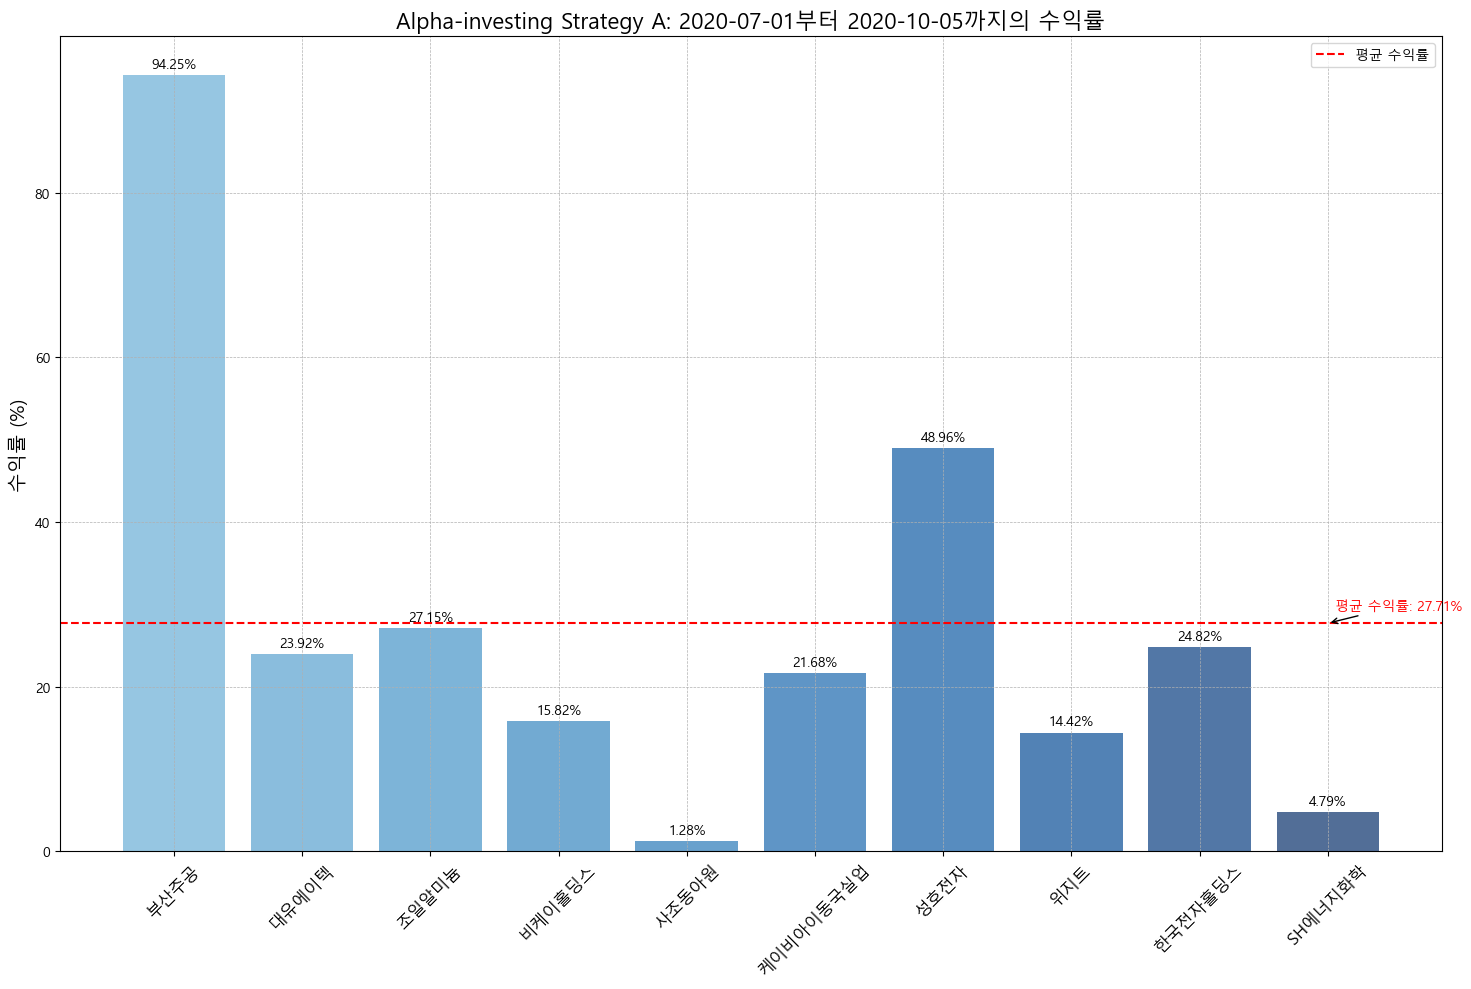

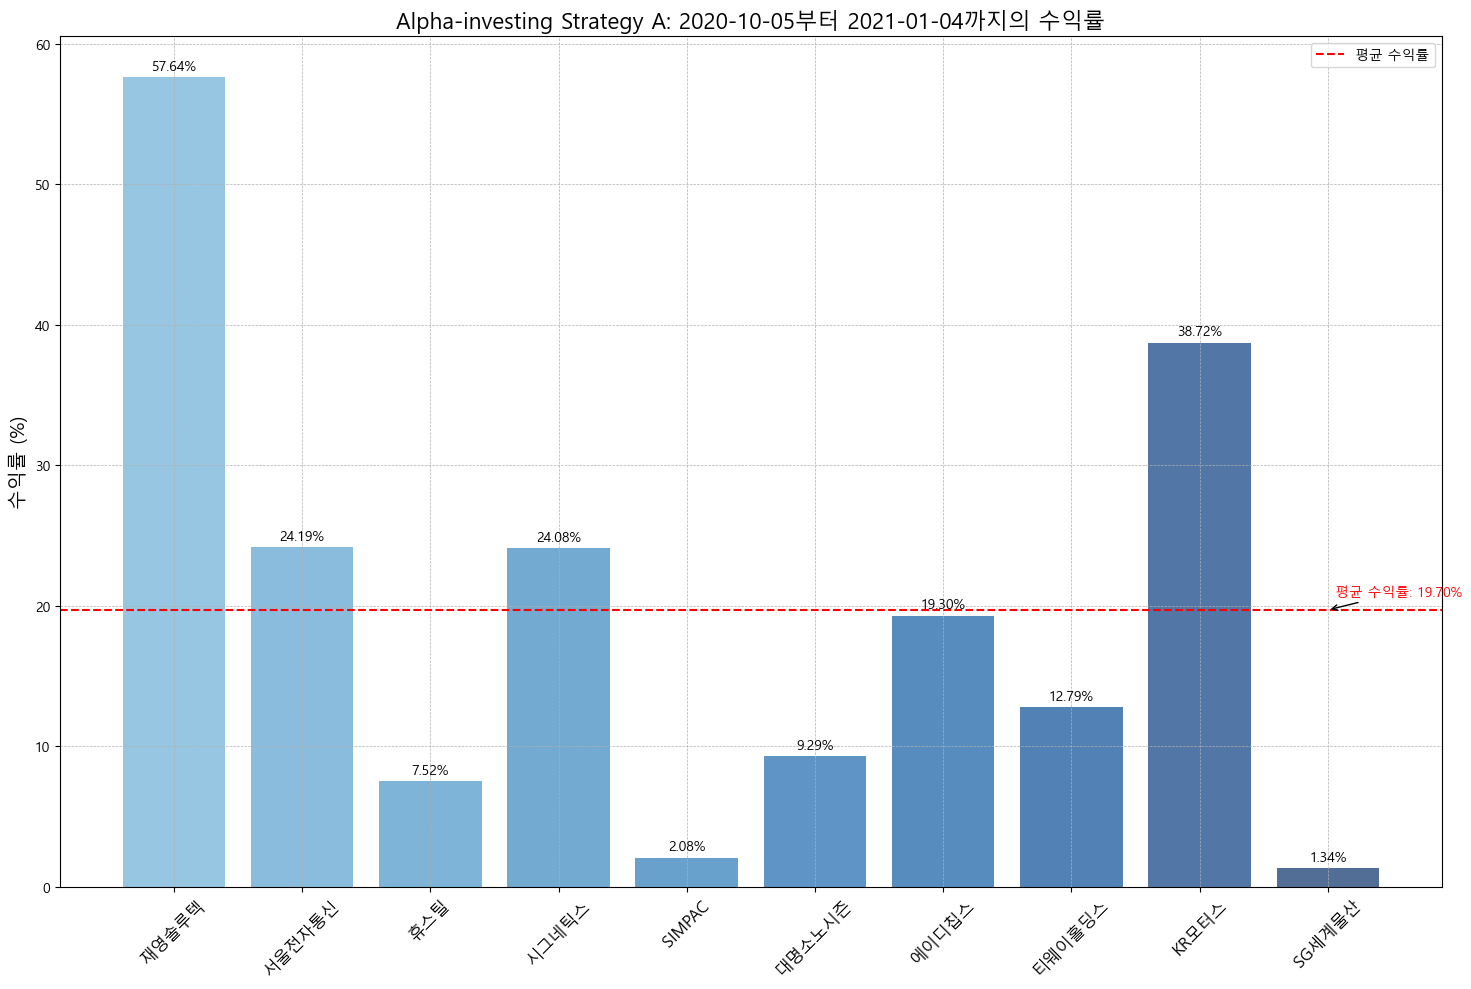

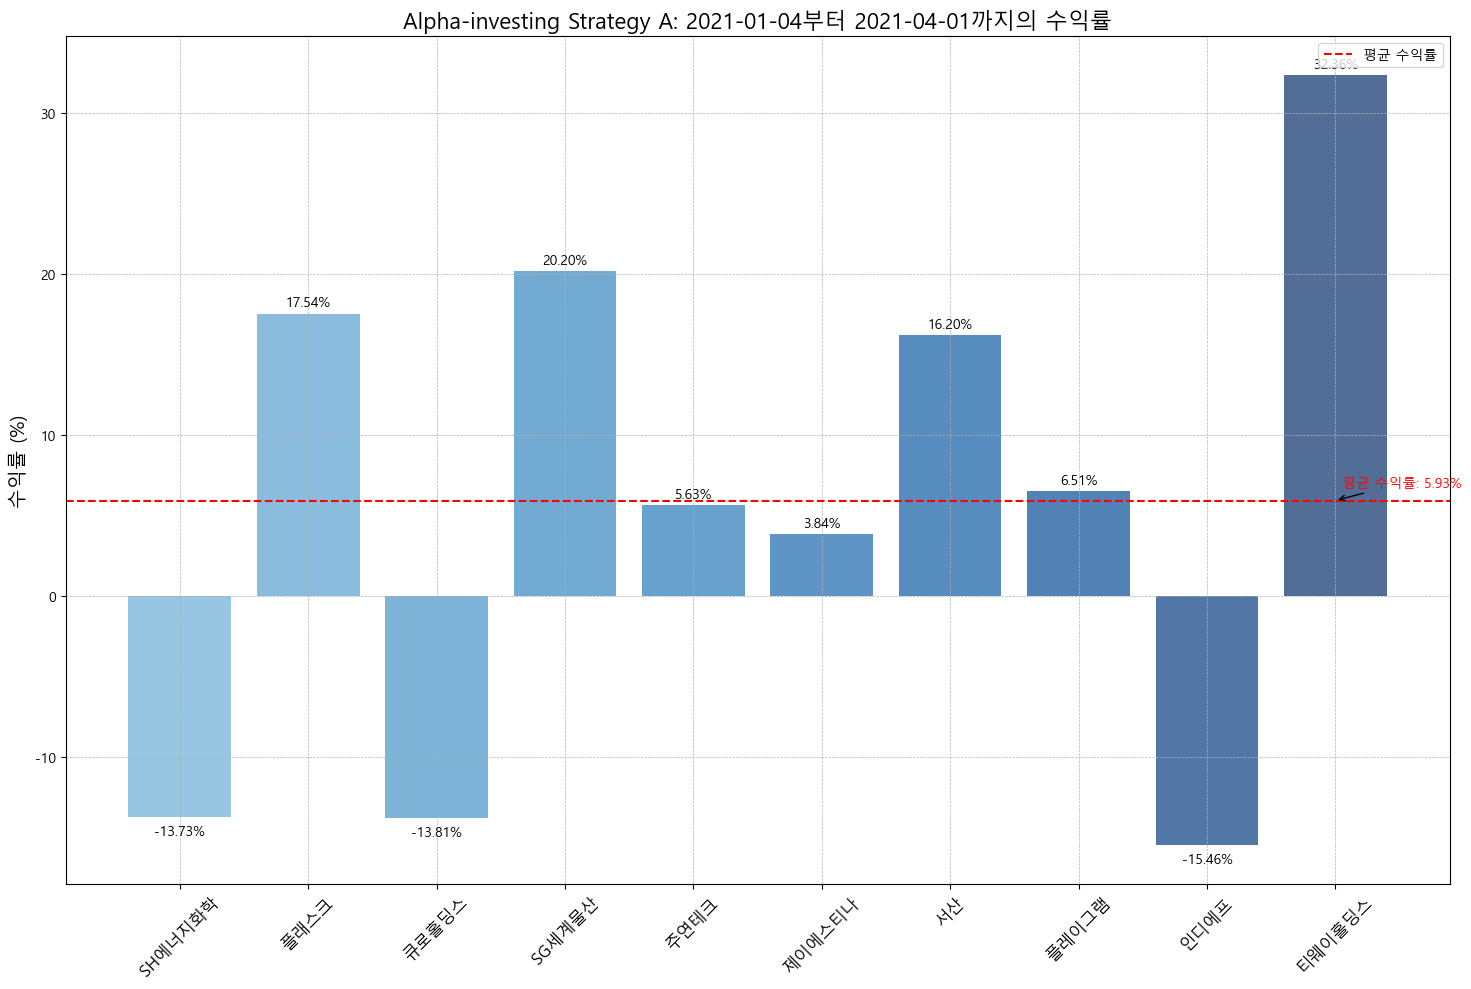

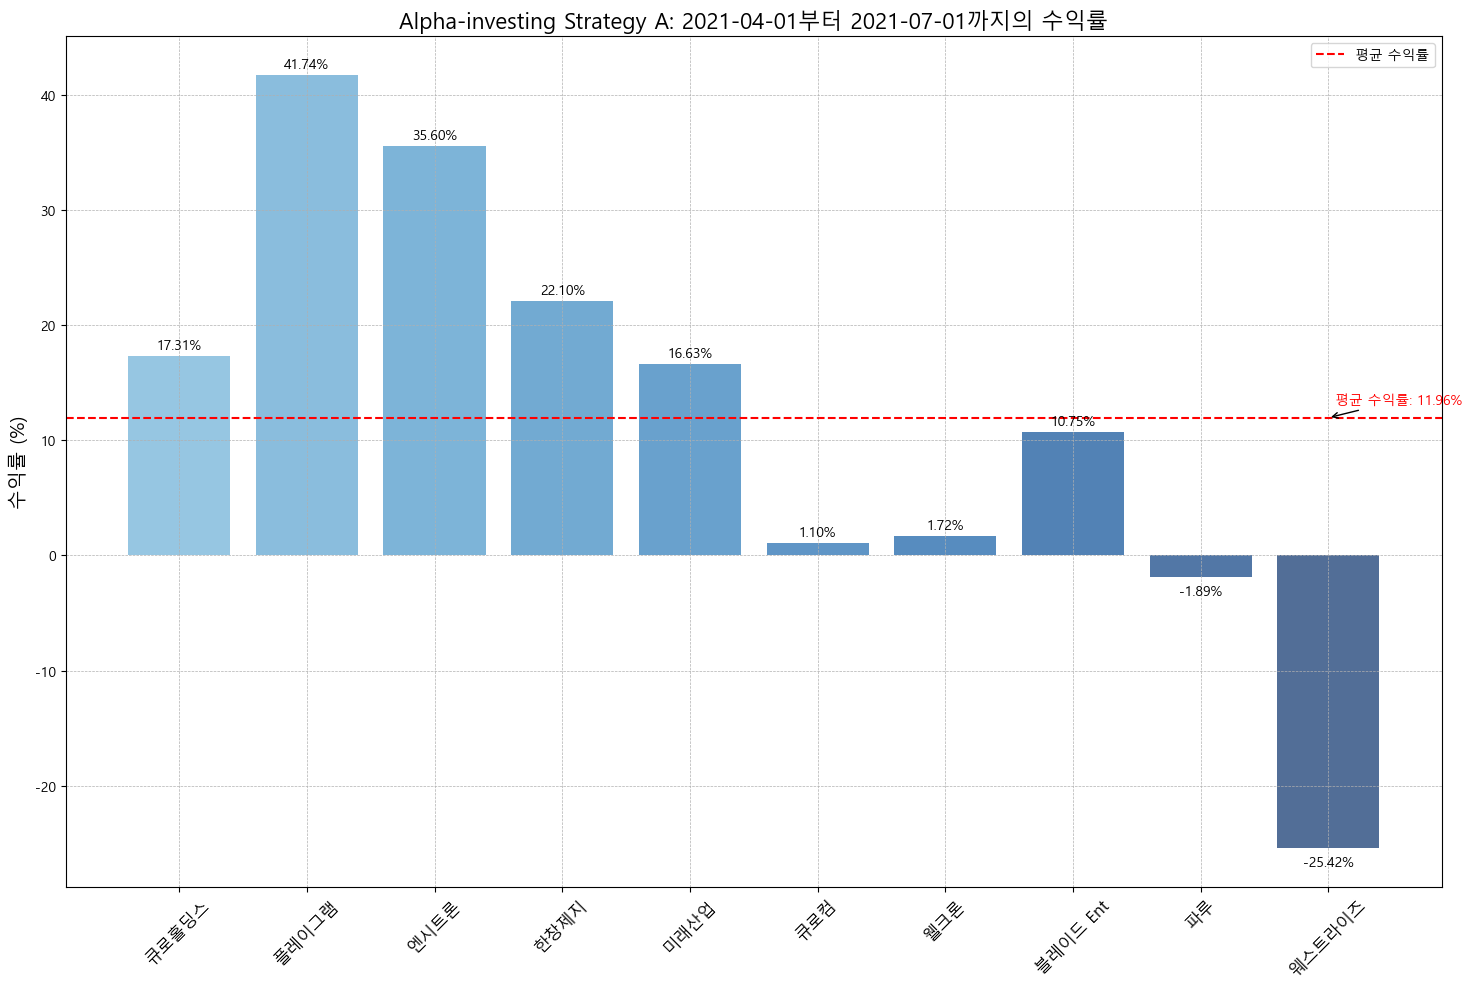

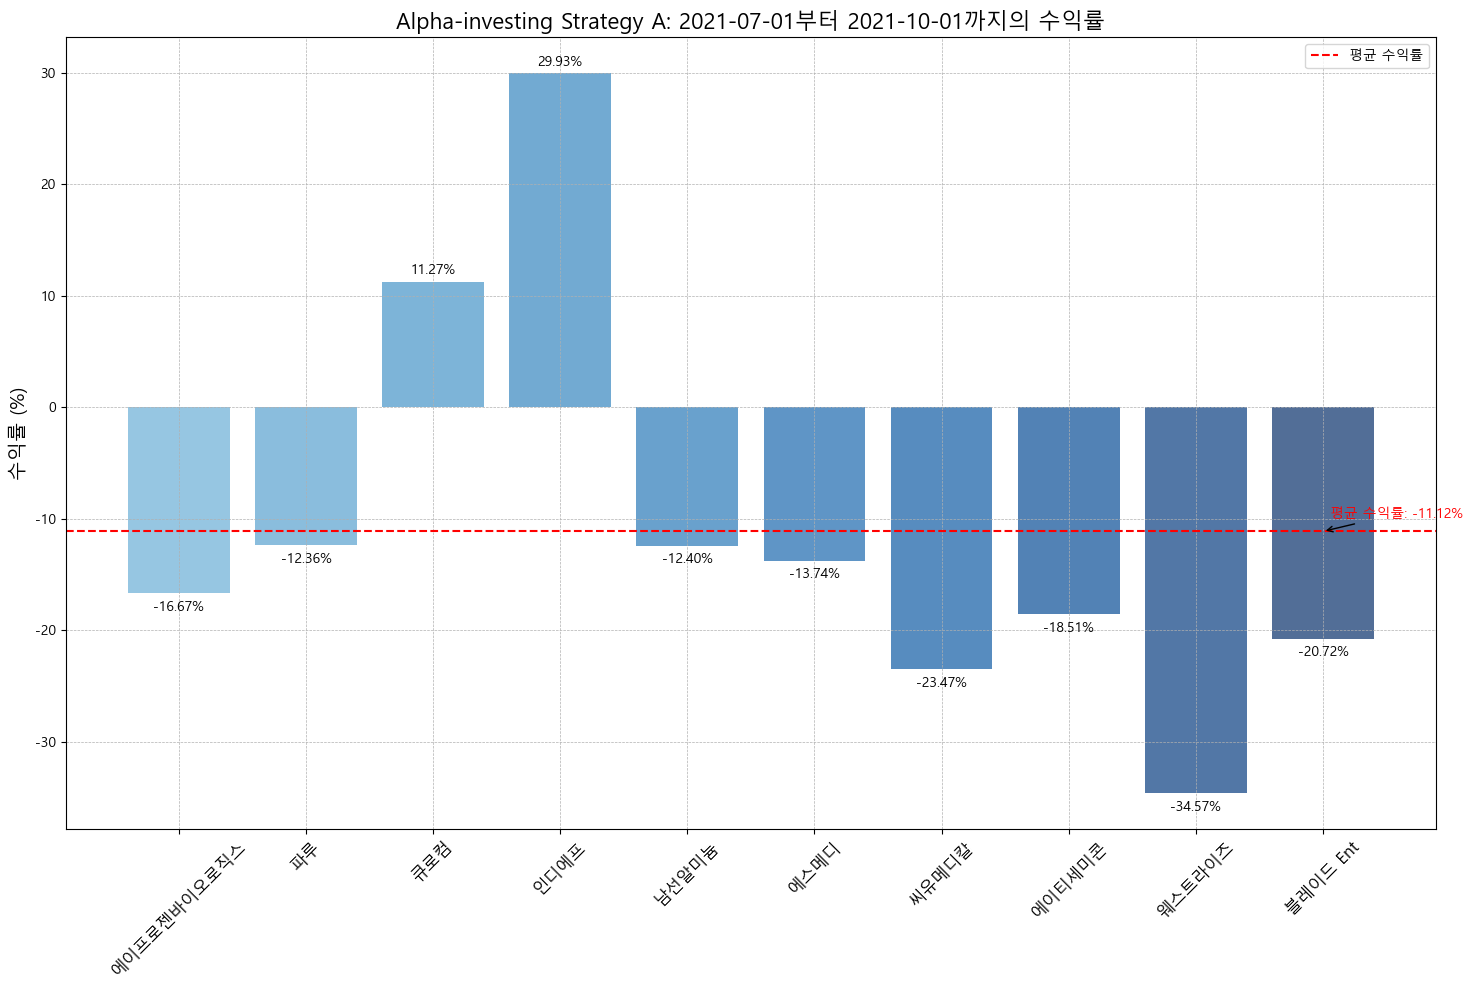

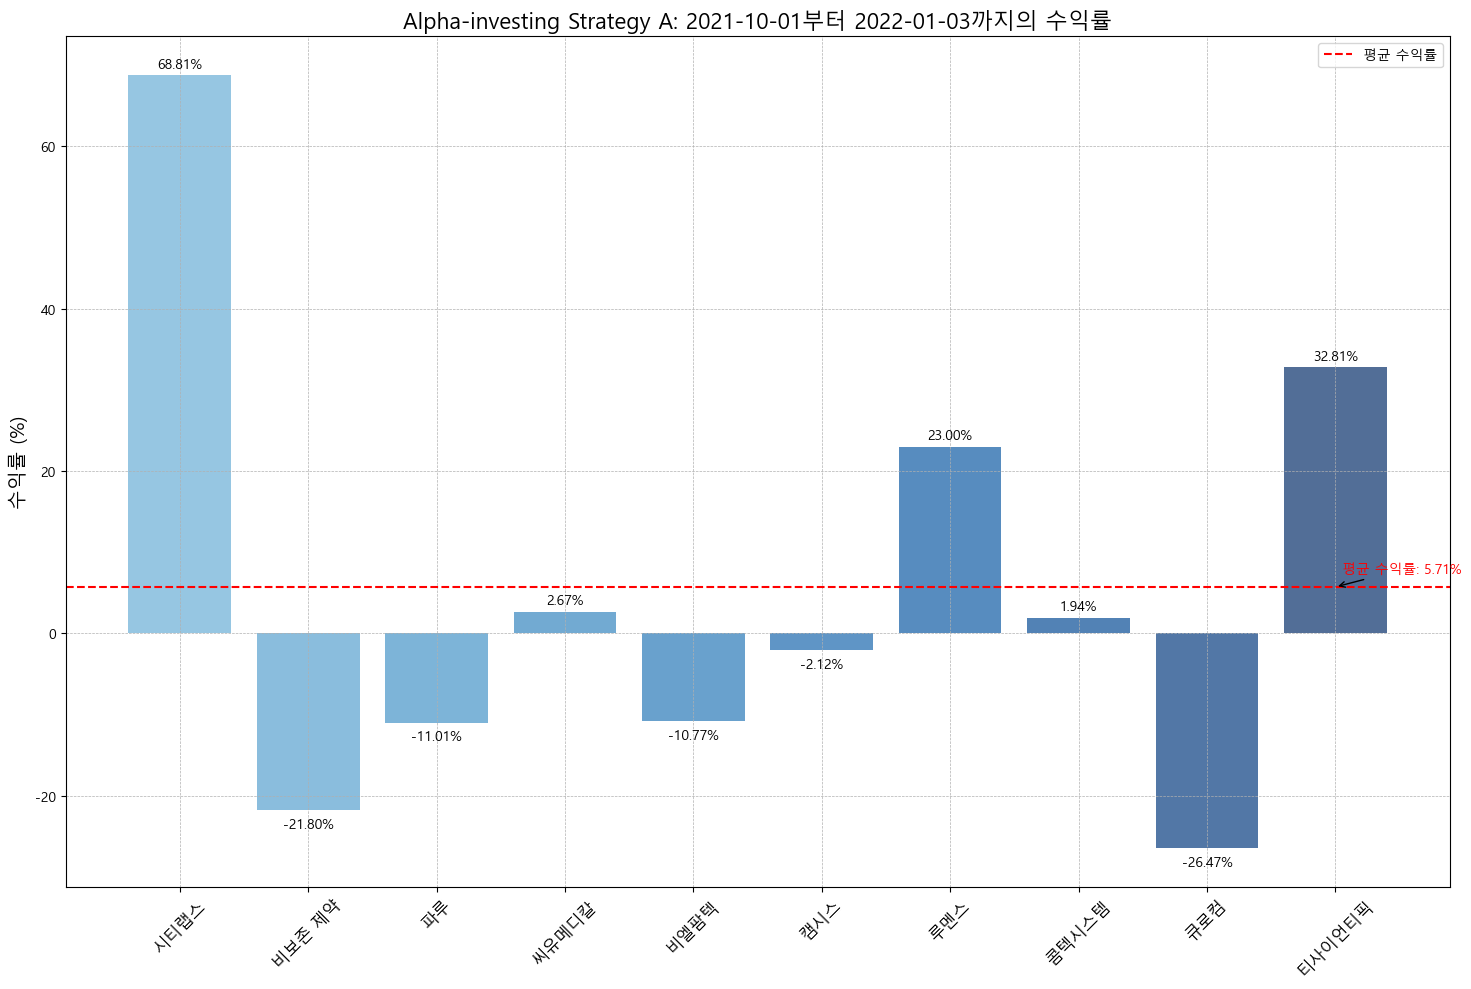

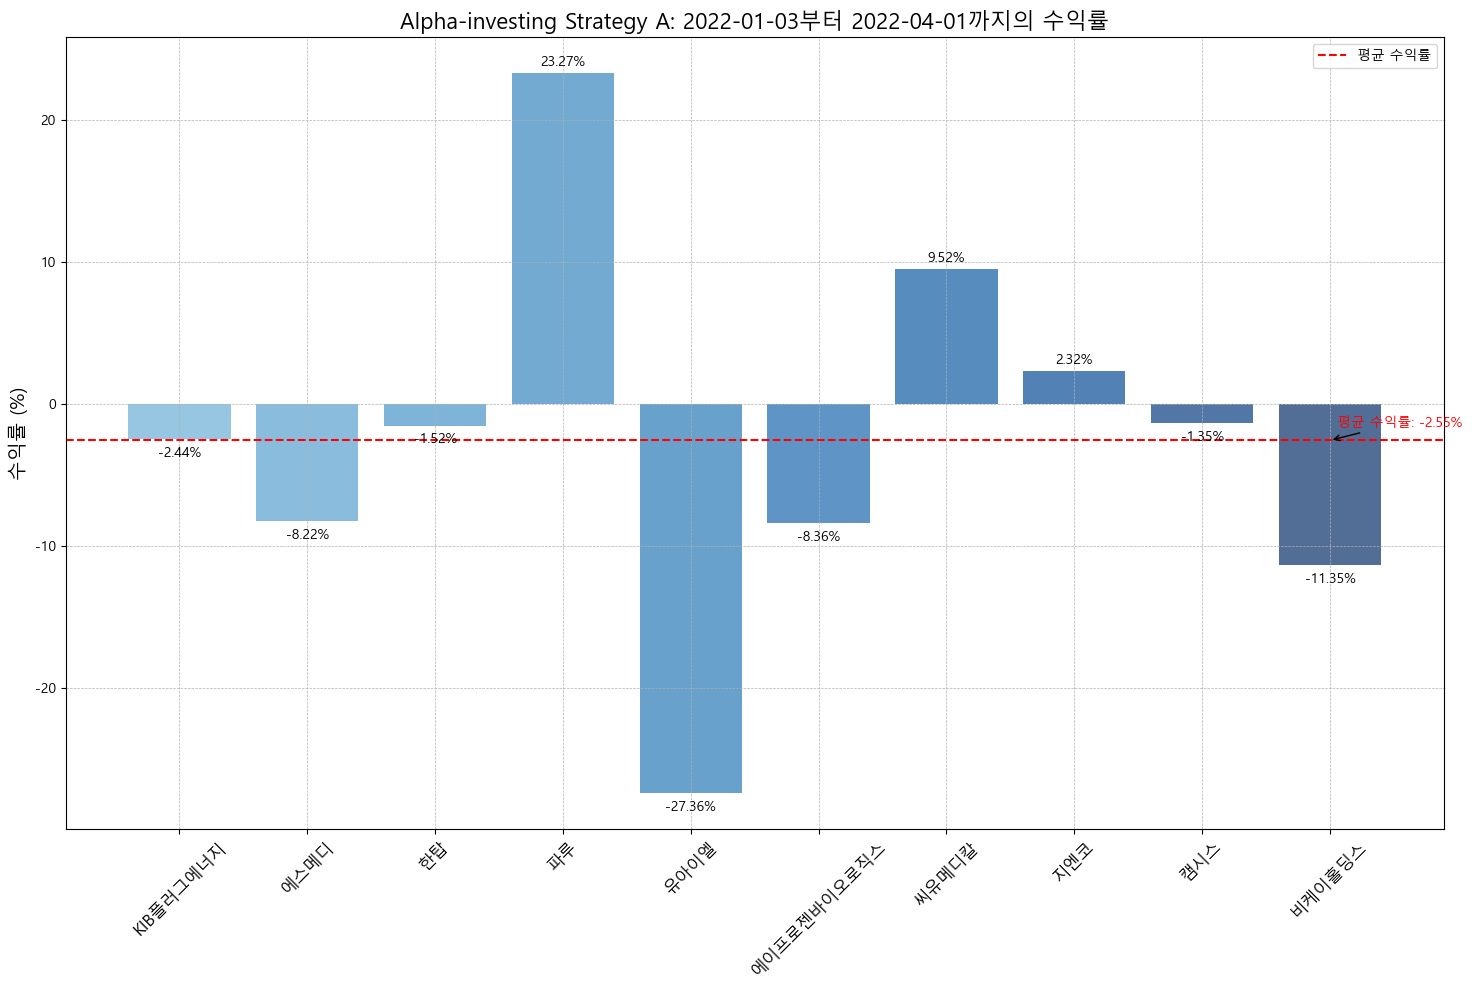

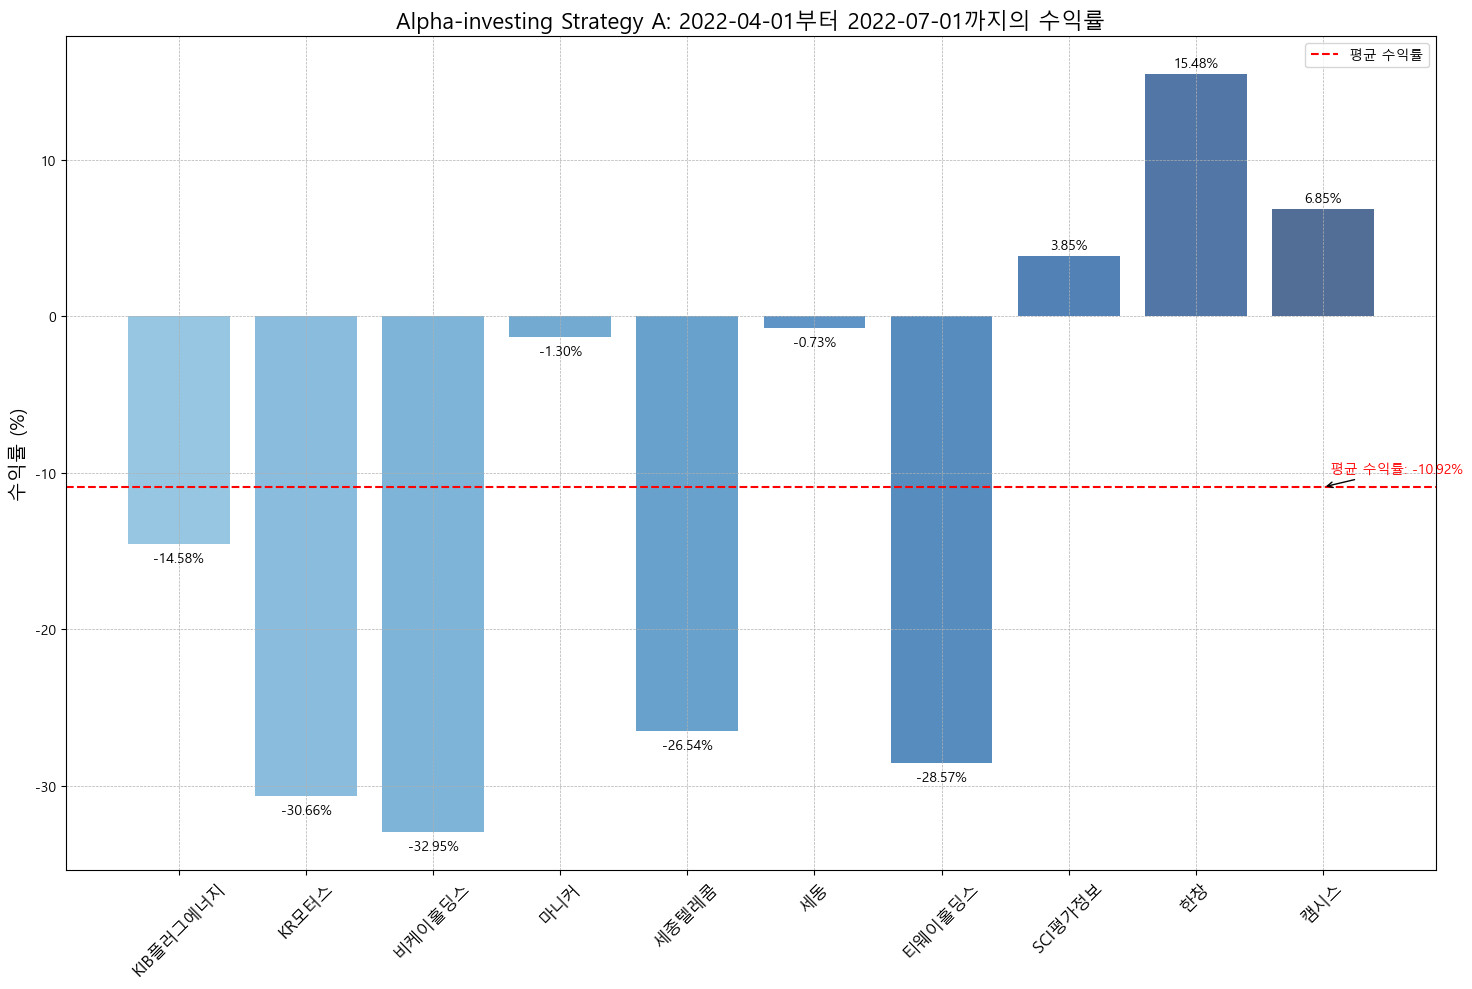

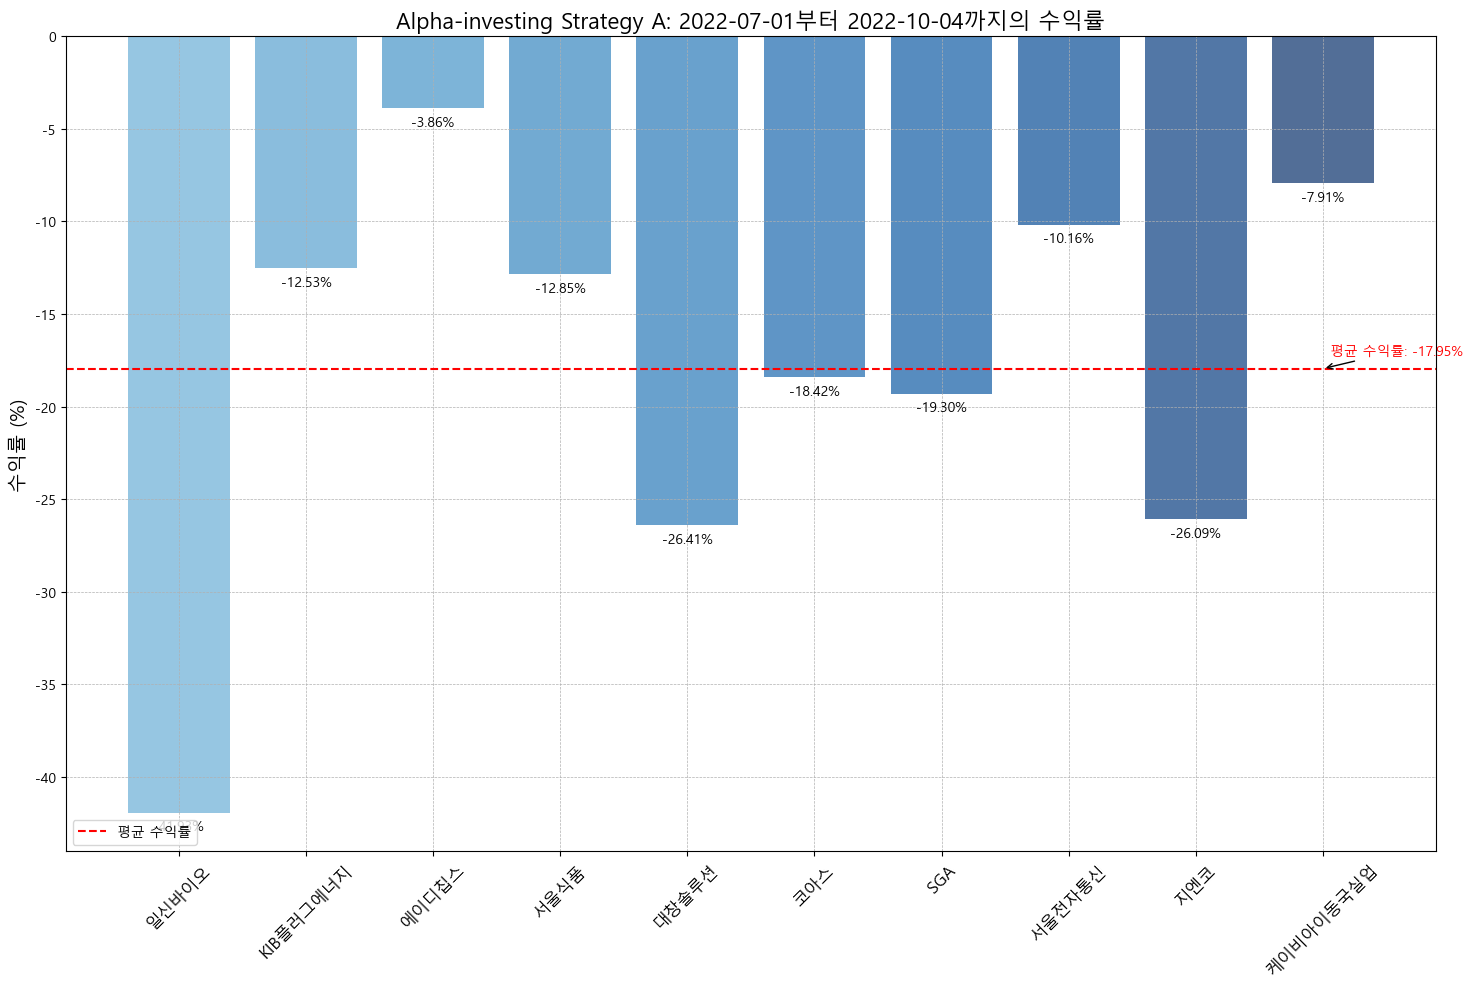

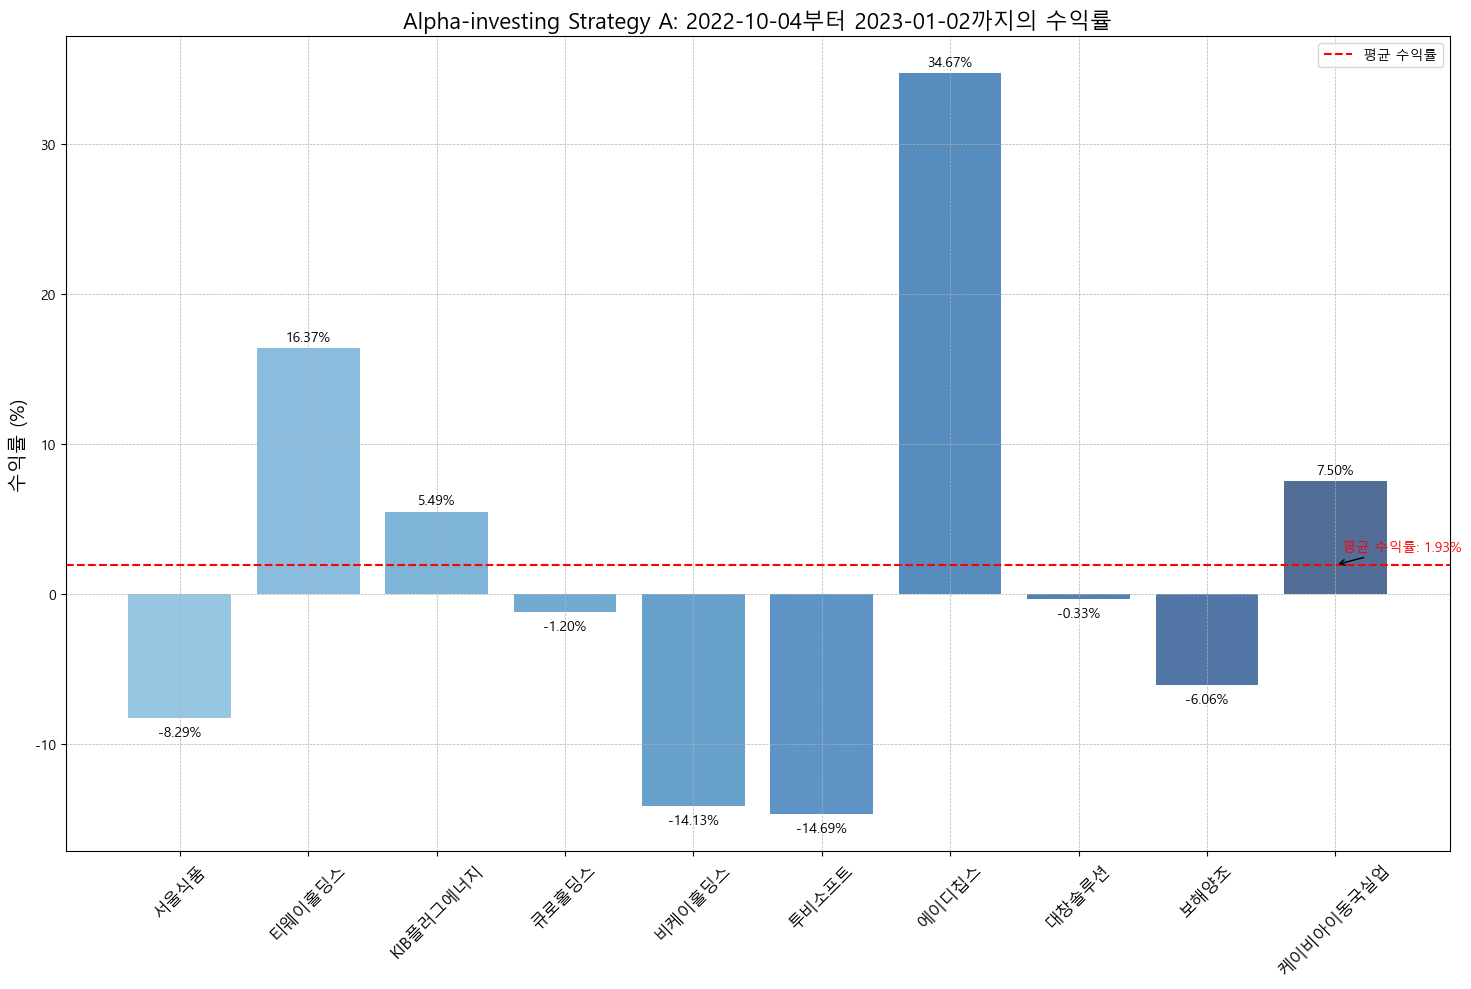

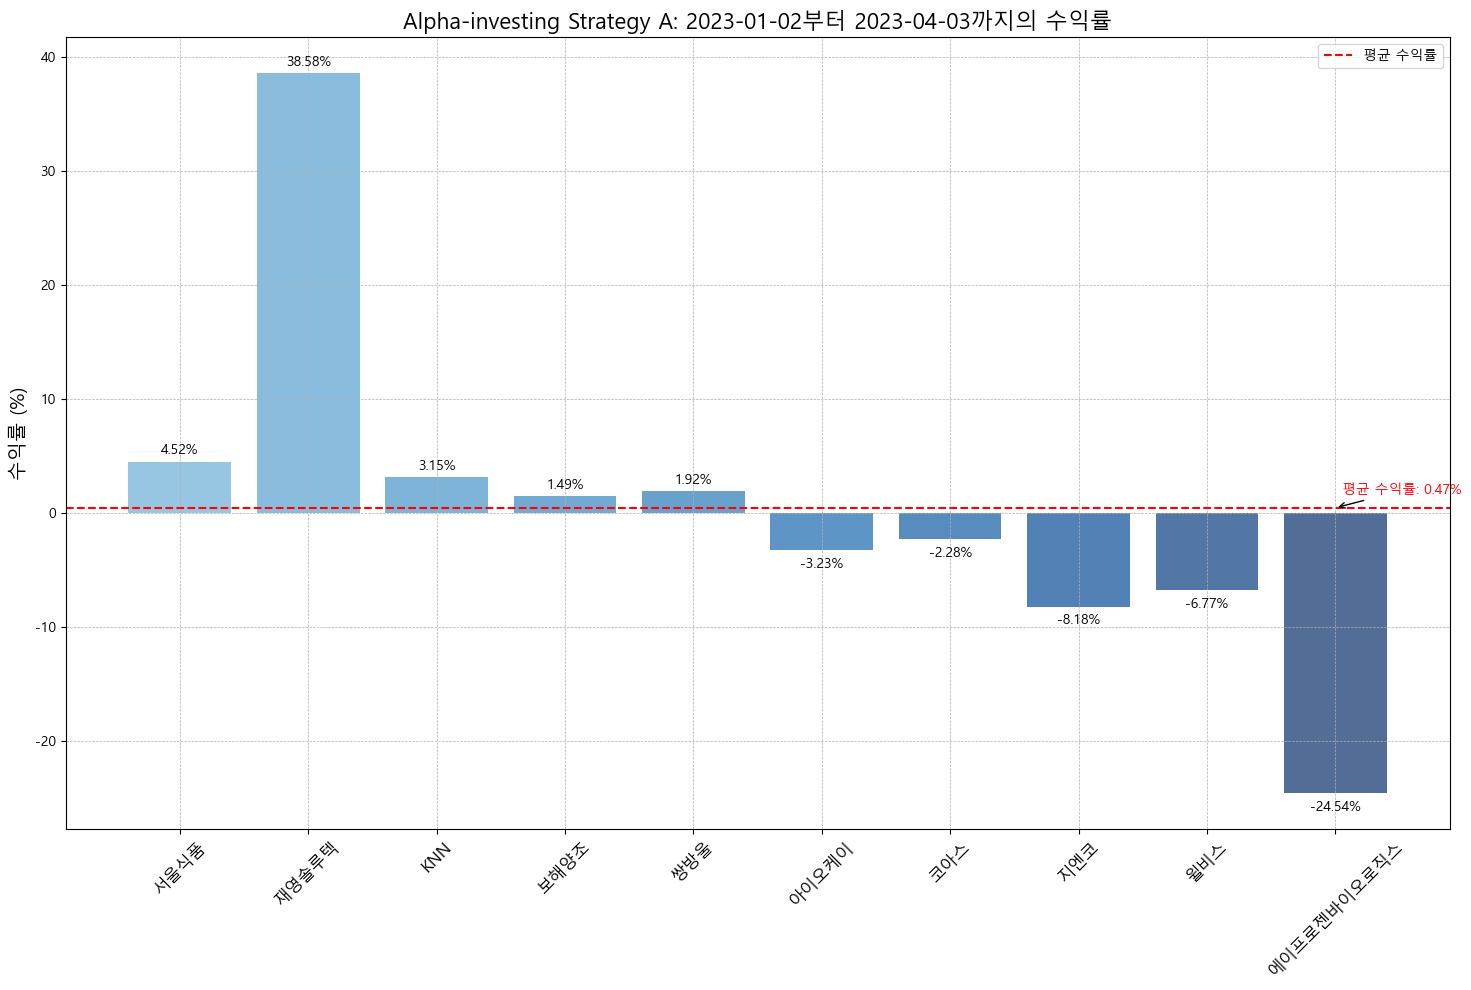

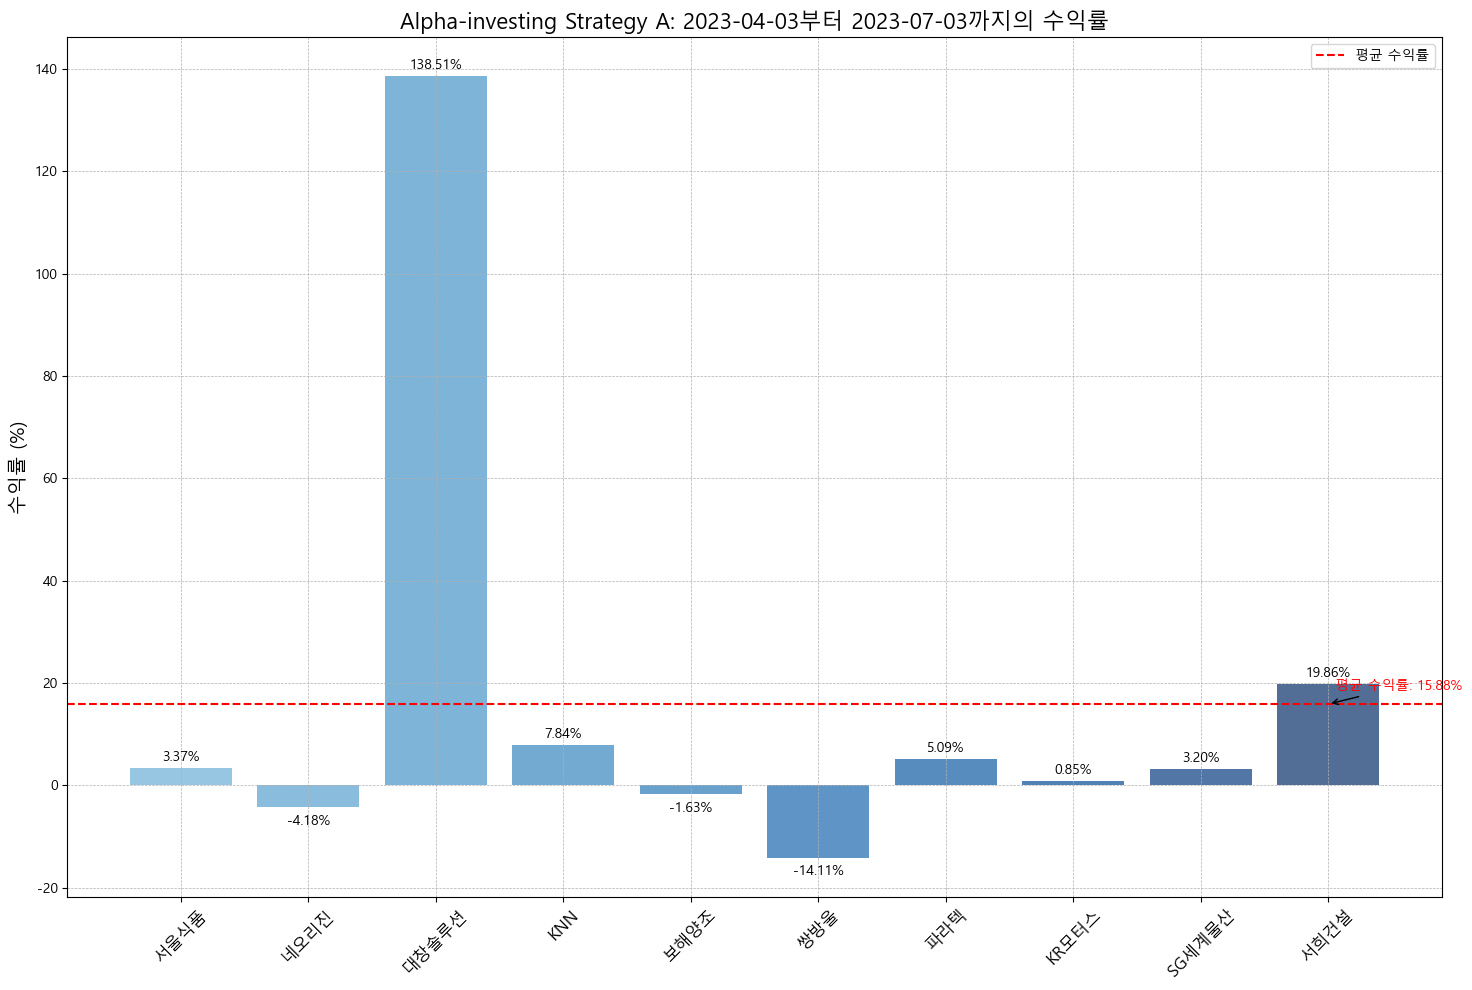

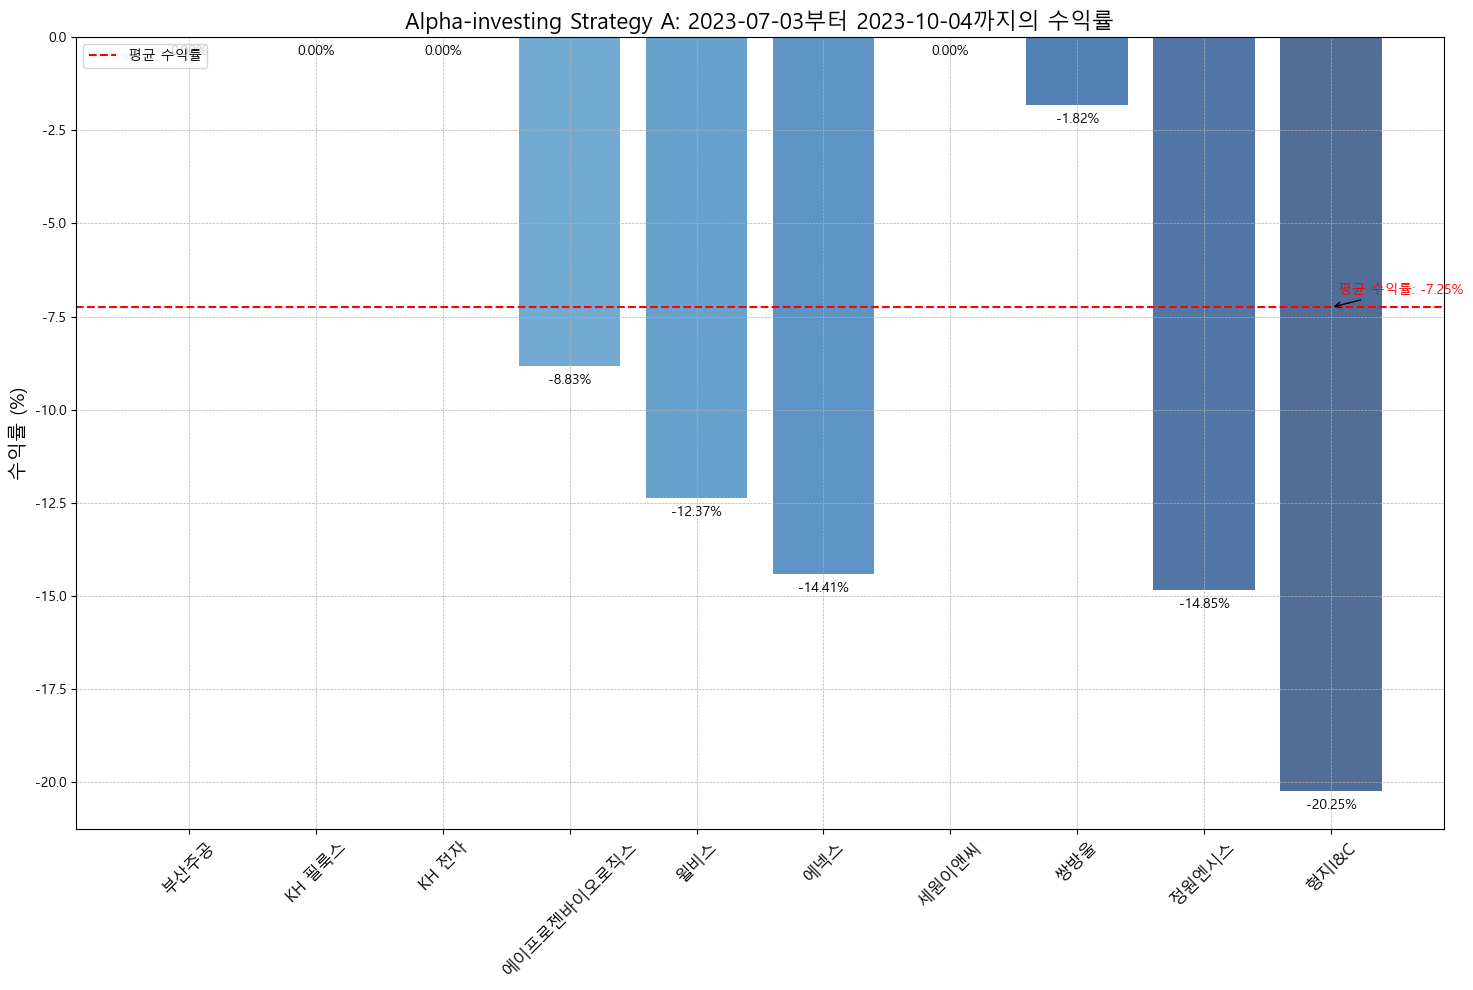

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrx import stock

# 그래프 관련 설정 초기화
def setup_plt():
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드 및 전처리
def load_and_process_data():
    close_df = pd.read_csv('close_df.csv')
    kospi_df = pd.read_csv('KOSPI Historical Data.csv')
    kosdaq_df = pd.read_csv('KOSDAQ Historical Data.csv')
    
    # 날짜 형식 변환 및 종가의 쉼표 제거
    kospi_df['Date'] = pd.to_datetime(kospi_df['Date'])
    kosdaq_df['Date'] = pd.to_datetime(kosdaq_df['Date'])
    kospi_df['Price'] = kospi_df['Price'].str.replace(',', '').astype(float)
    kosdaq_df['Price'] = kosdaq_df['Price'].str.replace(',', '').astype(float)

    return close_df, kospi_df, kosdaq_df

# 주어진 시작일과 종료일 사이의 수익률 계산 함수
def calculate_return(df, start_date, end_date):
    start_price = df[df['Date'] == start_date]['Price'].values[0]
    end_price = df[df['Date'] == end_date]['Price'].values[0]
    return (end_price - start_price) / start_price

# 각 리밸런싱일에 대해 전략에 따라 선정된 주식 반환
def get_stock_codes_by_date(close_df, rebalancing_dates):
    held_stocks_dict = {}
    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)
        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
        volatility = period_df[dropped_stocks].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
        held_stocks_dict[date] = selected_stocks
    return held_stocks_dict

# 주어진 기간 동안 선정된 주식의 수익률을 표시하는 그래프를 그리는 함수
def plot_selected_stock_returns(start_date, end_date, selected_stocks, company_names_mapping, close_df):
    period_df = close_df[(close_df['Date'] >= start_date) & (close_df['Date'] <= end_date)][selected_stocks]
    returns = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    average_return = returns.mean()

    fig, ax = plt.subplots(figsize=(15, 10))
    company_names = [company_names_mapping[code] for code in selected_stocks]
    colors = plt.cm.Blues(np.linspace(0.5, 1, len(returns)))
    bars = ax.bar(company_names, returns.values * 100, color=colors, alpha=0.7)
    ax.axhline(average_return * 100, color='red', linestyle='--', linewidth=1.5, label='평균 수익률')
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='black')
    ax.annotate(f'평균 수익률: {average_return * 100:.2f}%',
                xy=(len(company_names)-1, average_return * 100),
                xytext=(5, 10),
                textcoords='offset points',
                fontsize=10,
                color='red',
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    ax.set_title(f'Alpha-investing Strategy A: {start_date}부터 {end_date}까지의 수익률', fontsize=16)
    ax.set_ylabel('수익률 (%)', fontsize=14)
    ax.set_xticks(company_names)
    ax.set_xticklabels(company_names, rotation=45, fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()

# 메인 함수
def main():
    setup_plt()
    close_df, kospi_df, kosdaq_df = load_and_process_data()
    
# 리밸런싱일 정의하기
    rebalancing_dates = ['2014-01-02', '2014-04-01', '2014-07-01', '2014-10-01', '2015-01-02',
                    '2015-04-01', '2015-07-01', '2015-10-01', '2016-01-04',
                    '2016-04-01', '2016-07-01', '2016-10-04', '2017-01-02',
                    '2017-04-03', '2017-07-03', '2017-10-10', '2018-01-02',
                    '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02',
                    '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02',
                    '2020-04-01', '2020-07-01', '2020-10-05', '2021-01-04',
                    '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03',
                    '2022-04-01', '2022-07-01', '2022-10-04', '2023-01-02',
                    '2023-04-03', '2023-07-03', '2023-10-04']
    stock_codes_by_date = get_stock_codes_by_date(close_df, rebalancing_dates)
    stock_codes = [code for sublist in stock_codes_by_date.values() for code in sublist]

    company_names_mapping = get_company_names_from_pykrx(stock_codes)

    for date in rebalancing_dates[:-1]:
        next_date = rebalancing_dates[rebalancing_dates.index(date) + 1]
        selected_stocks = stock_codes_by_date[date]
        plot_selected_stock_returns(date, next_date, selected_stocks, company_names_mapping, close_df)

if __name__ == "__main__":
    main()
